# Análisis de Resultados: Pruebas de Transmisión SDR

Realizado por: David Enriquez, Giuliano Frieri y Leonardo Lizcano


## Preparación

### Importar Librerías

In [352]:
import pandas as pd
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_rel, ttest_ind, wilcoxon, f_oneway, kruskal, levene, shapiro
from pingouin import welch_anova
from sklearn.linear_model import LinearRegression

### Cargar Datos

In [353]:
def load_csv(directory, name):
    df = pd.read_csv(f"{directory}{name}.csv")
    df['prueba'] = name
    return df

### Limpieza de Datos

In [354]:
def limpiar_datos(df, columnas=None, iqr_multiplier=1.5):
    df_limpio = df.copy()
    
    if columnas is None:
        columnas = df_limpio.select_dtypes(include='number').columns.tolist()

    df_limpio = df_limpio.dropna(subset=columnas)

    for col in columnas:
        Q1 = df_limpio[col].quantile(0.25)
        Q3 = df_limpio[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR

        df_limpio = df_limpio[(df_limpio[col] >= lower_bound) & (df_limpio[col] <= upper_bound)]

    return df_limpio


### Transformación de Datos

In [355]:
def extraer_distancia(prueba):
    match = re.search(r'(?<![A-Za-z0-9])(\d+)m(?![A-Za-z])', prueba)
    if match:
        return float(match.group(1))
    return None

### Funciones de Análisis

#### Paquetes y Errores

In [356]:
def stats_paquetes(df):
    resumen = {}

    if 'mensaje' in df.columns:
        resumen['paquetes_totales'] = df['mensaje'].count()

    if 'crc_error' in df.columns:
        resumen['paquetes_ok'] = (df['crc_error'] == 0).sum()
        resumen['paquetes_err'] = (df['crc_error'] == 1).sum()
        resumen['crc_errors'] = df['crc_error'].sum()

    if 'previous_overflow_sum' in df.columns:
        resumen['overflow_sum'] = df['previous_overflow_sum'].sum()

    if resumen.get('paquetes_totales') and resumen.get('paquetes_ok') is not None:
        resumen['porcentaje_rx_ok'] = 100 * resumen['paquetes_ok'] / resumen['paquetes_totales']

    return pd.DataFrame([resumen])

#### Análisis Estadístico General

In [357]:
def describir_metricas(df):
    cols = df.select_dtypes(include=['number']).columns.tolist()
    return df[cols].describe()

#### Pruebas Estadísticas

In [358]:
def comparar_metricas_por_distancia(df, metrica, columna_grupo='distancia'):
    grupos = [grupo[metrica].dropna() for _, grupo in df.groupby(columna_grupo)]

    grupos = [g for g in grupos if len(g) > 0]
    if len(grupos) < 2:
        return {"metrica": metrica, "test": "Insuficiente", "p-valor": None}

    normal = all(shapiro(g)[1] > 0.05 for g in grupos)

    # Si hay normalidad
    if normal:
        _, p_levene = levene(*grupos)
        if p_levene > 0.05:
            # Varianzas homogéneas → ANOVA clásico
            stat, p = f_oneway(*grupos)
            test = "ANOVA"
        else:
            # Varianzas desiguales → Welch ANOVA
            resultado = welch_anova(data=df[[columna_grupo, metrica]].dropna(), dv=metrica, between=columna_grupo)
            stat = resultado["F"].iloc[0]
            p = resultado["p-unc"].iloc[0]
            test = "ANOVA de Welch"
    else:
        # No hay normalidad → Kruskal-Wallis
        stat, p = kruskal(*grupos)
        test = "Kruskal-Wallis"

    return {"metrica": metrica, "test": test, "p-valor": p}

#### Visualización de Resultados

In [359]:
#Histograma de las métricas
def plot_histograma(df):
    
    drop_cols = ['numero', 'crc_error', 'previous_overflow_sum', 'size (bytes)']
    for col in drop_cols:
        if col in df.columns:
            df = df.drop(col, axis=1)
    
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

    if not numeric_cols:
        print("No numeric columns found.")
        return

    fig, axes = plt.subplots(1, len(numeric_cols), figsize=(5 * len(numeric_cols), 4))

    if len(numeric_cols) == 1:
        axes = [axes]

    for i, col in enumerate(numeric_cols):
        sns.histplot(df[col].dropna(), kde=True, ax=axes[i], bins=7)
        axes[i].set_title(f'Histograma: {col}')
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

#Diagrama de correlación de las métricas
def plot_correlacion(df):
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

    if not numeric_cols:
        print("No numeric columns found for correlation.")
        return

    corr = df[numeric_cols].corr()

    plt.figure(figsize=(1.2 * len(numeric_cols), 1.2 * len(numeric_cols)))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
    plt.title("Correlación entre métricas")
    plt.tight_layout()
    plt.show()
    
def plot_metricas_por_distancia(df, metricas, tipo='box', columna_grupo='prueba'):
    metricas_presentes = [m for m in metricas if m in df.columns]
    fig, axes = plt.subplots(1, len(metricas_presentes), figsize=(5 * len(metricas_presentes), 4))

    if len(metricas_presentes) == 1:
        axes = [axes]  # Asegurar que axes sea iterable

    for i, metrica in enumerate(metricas_presentes):
        if tipo == 'box':
            sns.boxplot(data=df, x=columna_grupo, y=metrica, ax=axes[i])
        elif tipo == 'hist':
            sns.histplot(data=df, x=metrica, hue=columna_grupo, ax=axes[i], kde=True, element="step", common_norm=False)
        axes[i].set_title(f'{metrica} por {columna_grupo}')
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


## Ejecución

### Prueba #1

#### Cargado de Datos

In [360]:
df_8M21M = load_csv("preprocessed_csv/merge/", "8M-21m")
df_8M21M = limpiar_datos(df_8M21M)

df_8M50M = load_csv("preprocessed_csv/merge/", "8M-50m")
df_8M50M = limpiar_datos(df_8M50M)

display(df_8M21M)
display(df_8M50M)

,mensaje,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum,prueba
0,Giuliano 8MSPS:0,0,3.749480e-06,38.4686,-0.180415,1.047740,0,0,8M-21m
2,Giuliano 8MSPS:02,2,-5.659790e-07,14.9291,-0.180438,2.732200,0,0,8M-21m
4,Giuliano 8MSPS:06,6,-2.946630e-06,26.6316,-0.182944,3.960060,0,0,8M-21m
5,Giuliano 8MSPS:07,7,6.337590e-07,76.0791,-0.180620,4.510160,0,0,8M-21m
6,Giuliano 8MSPS:09,9,-1.389010e-06,47.8263,-0.180994,-3.729200,0,0,8M-21m
...,...,...,...,...,...,...,...,...,...
106,Giuliano 8MSPS:057,57,2.351720e-07,93.0293,-0.184805,0.443308,0,0,8M-21m
107,Giuliano 8MSPS:058,58,1.454880e-06,55.1818,-0.179641,1.936130,0,0,8M-21m
108,Giuliano 8MSPS:059,59,3.269460e-06,118.4090,-0.195724,2.363130,0,0,8M-21m
109,Giuliano 8MSPS:061,61,-7.096430e-07,42.9112,-0.168428,2.126810,0,0,8M-21m


,mensaje,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum,prueba
1,Mapuka 8MSPS:0,0,-1.929170e-07,42.9758,-0.191740,-1.571590,0,0,8M-50m
3,Mapuka 8MSPS:02,2,8.465100e-07,34.1057,-0.180297,-2.271010,0,0,8M-50m
5,Mapuka 8MSPS:04,4,-9.463990e-07,113.8820,-0.182903,-2.258650,0,0,8M-50m
6,Mapuka 8MSPS:05,5,-6.677280e-07,99.9164,-0.161030,-3.153940,0,0,8M-50m
7,Mapuka 8MSPS:06,6,9.813620e-07,78.1226,-0.196773,-0.781148,0,0,8M-50m
...,...,...,...,...,...,...,...,...,...
107,Mapuka 8MSPS:054,54,-2.583980e-06,70.6769,-0.210327,-0.303262,0,0,8M-50m
108,Mapuka 8MSPS:055,55,-2.410470e-06,21.6986,-0.185351,-2.083690,0,0,8M-50m
109,Mapuka 8MSPS:056,56,-2.484940e-07,100.9690,-0.174419,-1.050660,0,0,8M-50m
111,Mapuka 8MSPS:058,58,1.600550e-06,71.2000,-0.185304,-2.862330,0,0,8M-50m


#### Paquetes y Errores

In [361]:
stats_packs_8M21M = stats_paquetes(df_8M21M)
stats_packs_8M50M = stats_paquetes(df_8M50M)

display(stats_packs_8M21M)
display(stats_packs_8M50M)

,paquetes_totales,paquetes_ok,paquetes_err,crc_errors,overflow_sum,porcentaje_rx_ok
0,101,101,0,0,0,100.0


,paquetes_totales,paquetes_ok,paquetes_err,crc_errors,overflow_sum,porcentaje_rx_ok
0,96,96,0,0,0,100.0


#### Análisis Estadístico General

In [362]:
describir_metricas_8M21M = describir_metricas(df_8M21M)
describir_metricas_8M50M = describir_metricas(df_8M50M)

display(describir_metricas_8M21M)
display(describir_metricas_8M50M)

,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum
count,101.000000,1.010000e+02,101.000000,101.000000,101.000000,101.0,101.0
mean,30.336634,-3.101550e-08,62.431649,-0.184021,2.146952,0.0,0.0
std,16.828712,2.291081e-06,36.245457,0.009117,2.209084,0.0,0.0
min,0.000000,-3.898120e-06,0.740601,-0.210956,-3.729200,0.0,0.0
25%,16.000000,-1.728910e-06,30.393300,-0.190386,0.940855,0.0,0.0
50%,31.000000,-1.437670e-07,62.363400,-0.184448,2.422630,0.0,0.0
75%,44.000000,1.849760e-06,93.081900,-0.178410,3.803880,0.0,0.0
max,62.000000,3.981860e-06,123.784000,-0.158849,6.007770,0.0,0.0


,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum
count,96.000000,9.600000e+01,96.000000,96.000000,96.000000,96.0,96.0
mean,27.197917,1.943204e-07,56.795038,-0.188035,-3.209841,0.0,0.0
std,16.736106,2.116538e-06,33.995455,0.010463,2.511712,0.0,0.0
min,0.000000,-3.862850e-06,-0.281247,-0.215154,-9.898410,0.0,0.0
25%,12.750000,-1.306070e-06,31.987325,-0.193843,-4.809972,0.0,0.0
50%,25.500000,1.077820e-08,48.646200,-0.188545,-2.845475,0.0,0.0
75%,41.500000,1.824347e-06,78.744500,-0.181548,-1.211565,0.0,0.0
max,59.000000,3.983370e-06,127.076000,-0.161030,1.818130,0.0,0.0


#### Visualización de Resultados

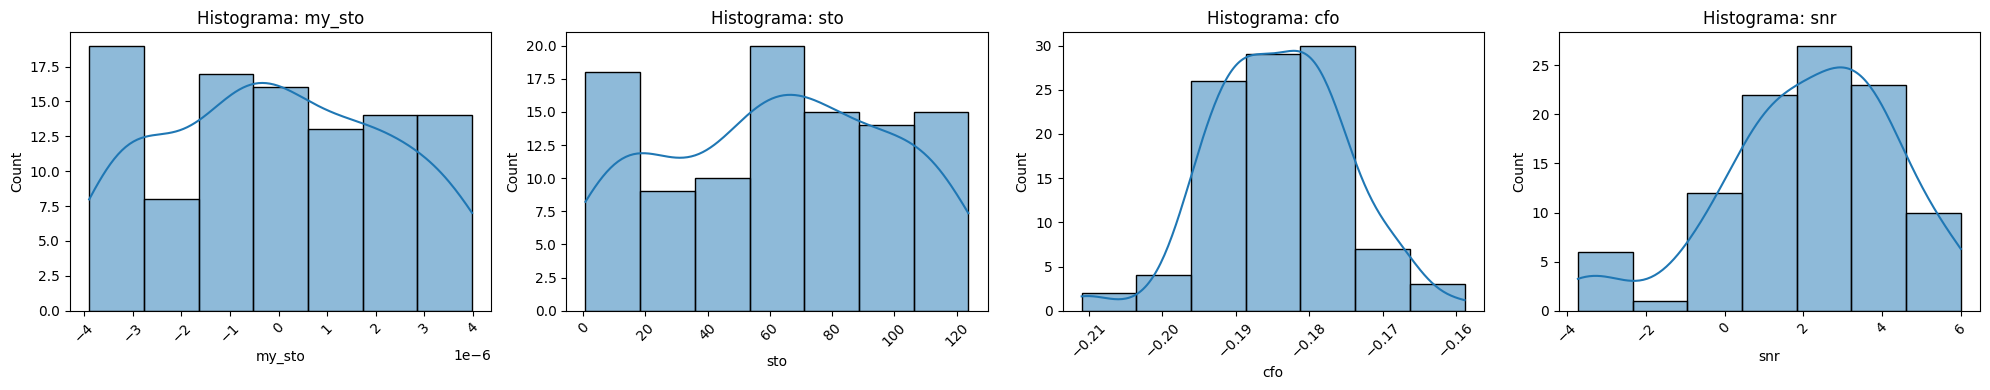

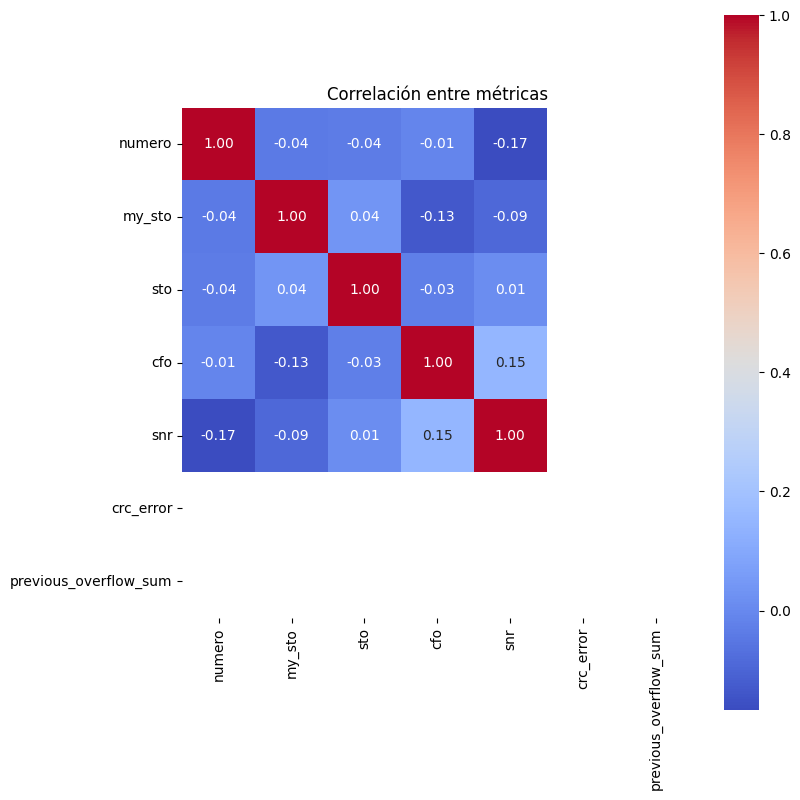

In [363]:
plot_histograma(df_8M21M)
plot_correlacion(df_8M21M)

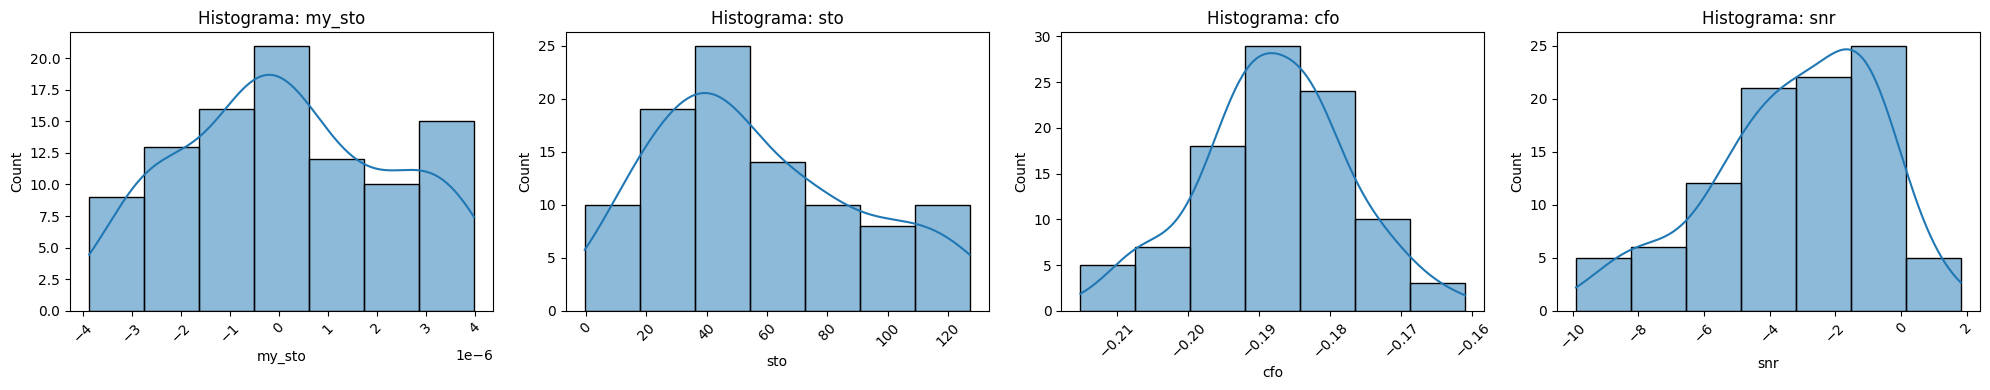

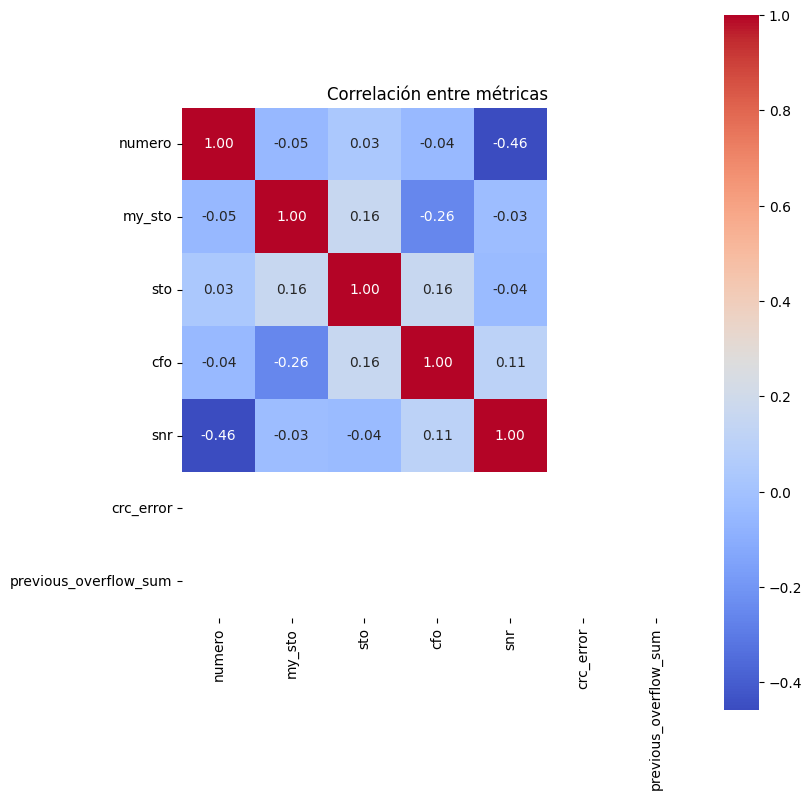

In [364]:
plot_histograma(df_8M50M)
plot_correlacion(df_8M50M)

### Prueba #2

#### Cargado de Datos

In [365]:
#PRUEBAS A 1M DE DISTANCIA
df_4M1M = load_csv("03-04-2025_csv/", "4M-1m-1")
df_4M1M = limpiar_datos(df_4M1M)

df_8M1M = load_csv("03-04-2025_csv/", "8M-1m-1")
df_8M1M = limpiar_datos(df_8M1M)

df_N_4M1M = load_csv("Neisser_03-04-2025_csv/", "1m4msps")
df_N_4M1M = limpiar_datos(df_N_4M1M)

df_N_8M1M = load_csv("Neisser_03-04-2025_csv/", "1m8msps")
df_N_8M1M = limpiar_datos(df_N_8M1M)

display(df_4M1M.head())
display(df_8M1M.head())
display(df_N_4M1M.head())
display(df_N_8M1M.head())

,mensaje,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum,prueba
0,1M 4MSPS:0,0,5.400320e-07,48.0674,-0.177525,20.6317,0,0,4M-1m-1
1,1M 4MSPS:01,1,1.019250e-06,59.1273,-0.180525,18.9488,0,0,4M-1m-1
2,1M 4MSPS:02,2,2.484900e-06,57.3105,-0.185939,20.3911,0,0,4M-1m-1
3,1M 4MSPS:03,3,1.044650e-06,19.1305,-0.179333,20.4081,0,0,4M-1m-1
4,1M 4MSPS:04,4,1.820470e-06,123.2270,-0.182460,20.0183,0,0,4M-1m-1


,mensaje,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum,prueba
0,1M 8MSPS:0,0,2.799170e-07,58.0349,-0.182969,20.2908,0,0,8M-1m-1
1,1M 8MSPS:01,1,1.550390e-06,89.1937,-0.184022,20.3064,0,0,8M-1m-1
2,1M 8MSPS:02,2,4.983300e-07,46.0622,-0.179368,20.6883,0,0,8M-1m-1
4,1M 8MSPS:04,4,2.950420e-06,6.3687,-0.184068,20.2472,0,0,8M-1m-1
5,1M 8MSPS:05,5,2.558040e-06,67.3196,-0.187601,20.4084,0,0,8M-1m-1


,mensaje,numero,rssi (dBm),snr (dB),size (bytes),prueba
10,1M 4MSPS:010,10,-31,10.50,12,1m4msps
11,1M 4MSPS:011,11,-31,10.75,12,1m4msps
12,1M 4MSPS:012,12,-31,10.25,12,1m4msps
14,1M 4MSPS:014,14,-31,11.00,12,1m4msps
16,1M 4MSPS:016,16,-31,10.25,12,1m4msps


,mensaje,numero,rssi (dBm),snr (dB),size (bytes),prueba
10,1M 8MSPS:010,10,-30,10.75,12,1m8msps
11,1M 8MSPS:011,11,-30,11.00,12,1m8msps
12,1M 8MSPS:012,12,-31,11.00,12,1m8msps
13,1M 8MSPS:013,13,-31,10.50,12,1m8msps
14,1M 8MSPS:014,14,-31,10.75,12,1m8msps


In [366]:
#PRUEBAS A 40M DE DISTANCIA
df_4M40M = load_csv("03-04-2025_csv/", "4M-40m-1")
df_4M40M = limpiar_datos(df_4M40M)

df_8M40M = load_csv("03-04-2025_csv/", "8M-40m-1")
df_8M40M = limpiar_datos(df_8M40M)

df_N_4M40M = load_csv("Neisser_03-04-2025_csv/", "40m4msps")
df_N_4M40M = limpiar_datos(df_N_4M40M)

df_N_8M40M = load_csv("Neisser_03-04-2025_csv/", "40m8msps")
df_N_8M40M = limpiar_datos(df_N_8M40M)

display(df_4M40M.head())
display(df_8M40M.head())
display(df_N_4M40M.head())
display(df_N_8M40M.head())

,mensaje,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum,prueba
0,40M 4MSPS:0,0,4.309830e-07,40.0538,-0.176547,20.0248,0,0,4M-40m-1
1,40M 4MSPS:01,1,-1.902220e-06,40.7621,-0.174969,20.3771,0,0,4M-40m-1
2,40M 4MSPS:02,2,1.886170e-07,36.0235,-0.180400,20.4179,0,0,4M-40m-1
3,40M 4MSPS:03,3,-9.543910e-07,94.8806,-0.177438,20.4732,0,0,4M-40m-1
4,40M 4MSPS:04,4,1.617200e-06,88.2020,-0.185021,19.7842,0,0,4M-40m-1


,mensaje,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum,prueba
0,40M 8MSPS:0,0,1.223950e-06,109.1530,-0.181409,19.7983,0,0,8M-40m-1
1,40M 8MSPS:01,1,1.374560e-06,22.1717,-0.183081,19.9153,0,0,8M-40m-1
2,40M 8MSPS:02,2,9.930730e-07,35.1240,-0.182375,20.1746,0,0,8M-40m-1
4,40M 8MSPS:04,4,2.715640e-06,114.3390,-0.189435,20.0185,0,0,8M-40m-1
5,40M 8MSPS:05,5,3.126120e-06,78.3907,-0.187215,20.1207,0,0,8M-40m-1


,mensaje,numero,rssi (dBm),snr (dB),size (bytes),prueba
10,40M 4MSPS:010,10,-69,12.00,13,40m4msps
11,40M 4MSPS:011,11,-71,11.50,13,40m4msps
12,40M 4MSPS:012,12,-71,11.00,13,40m4msps
13,40M 4MSPS:013,13,-70,11.00,13,40m4msps
14,40M 4MSPS:014,14,-70,10.75,13,40m4msps


,mensaje,numero,rssi (dBm),snr (dB),size (bytes),prueba
10,40M 8MSPS:010,10,-69,12.00,13,40m8msps
11,40M 8MSPS:013,13,-70,11.25,13,40m8msps
12,40M 8MSPS:014,14,-70,10.75,13,40m8msps
13,40M 8MSPS:015,15,-71,11.00,13,40m8msps
14,40M 8MSPS:016,16,-74,11.50,13,40m8msps


In [367]:
#PRUEBAS A 80M DE DISTANCIA
df_4M80M = load_csv("03-04-2025_csv/", "4M-80m-1")
df_4M80M = limpiar_datos(df_4M80M)

df_8M80M = load_csv("03-04-2025_csv/", "8M-80m-1")
df_8M80M = limpiar_datos(df_8M80M)

df_N_4M80M = load_csv("Neisser_03-04-2025_csv/", "80m4msps")
df_N_4M80M = limpiar_datos(df_N_4M80M)

df_N_8M80M = load_csv("Neisser_03-04-2025_csv/", "80m8msps")
df_N_8M80M = limpiar_datos(df_N_8M80M)

display(df_4M80M.head())
display(df_8M80M.head())
display(df_N_4M80M.head())
display(df_N_8M80M.head())

,mensaje,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum,prueba
0,80M 4MSPS:0,0,1.547260e-06,88.19330,-0.185440,10.291800,0,0,4M-80m-1
1,80M 4MSPS:01,1,1.754640e-06,52.21920,-0.179992,9.163980,0,0,4M-80m-1
2,80M 4MSPS:02,2,-1.774910e-06,44.77800,-0.180113,2.684410,0,0,4M-80m-1
3,80M 4MSPS:03,3,2.926780e-06,7.36574,-0.179554,0.946018,0,0,4M-80m-1
4,80M 4MSPS:04,4,-2.042420e-07,111.97400,-0.172717,8.031180,0,0,4M-80m-1


,mensaje,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum,prueba
0,80M 8MSPS:0,0,2.223310e-06,95.2778,-0.191848,7.992830,0,0,8M-80m-1
1,80M 8MSPS:01,1,-2.306760e-06,79.7116,-0.165455,2.763030,0,0,8M-80m-1
2,80M 8MSPS:02,2,-1.185590e-06,37.8517,-0.175385,-4.431020,0,0,8M-80m-1
3,80M 8MSPS:03,3,3.476260e-06,30.4344,-0.189023,-0.274857,0,0,8M-80m-1
4,80M 8MSPS:04,4,2.429480e-08,60.0029,-0.179658,1.650910,0,0,8M-80m-1


,mensaje,numero,rssi (dBm),snr (dB),size (bytes),prueba
11,80M 4MSPS:012,12,-88,12.00,13,80m4msps
12,80M 4MSPS:013,13,-86,11.75,13,80m4msps
13,80M 4MSPS:014,14,-85,11.50,13,80m4msps
14,80M 4MSPS:015,15,-92,10.50,13,80m4msps
15,80M 4MSPS:016,16,-87,11.50,13,80m4msps


,mensaje,numero,rssi (dBm),snr (dB),size (bytes),prueba
9,80M 8MSPS:010,10,-91,10.25,13,80m8msps
10,80M 8MSPS:011,11,-95,10.00,13,80m8msps
11,80M 8MSPS:012,12,-91,10.50,13,80m8msps
12,80M 8MSPS:013,13,-83,12.25,13,80m8msps
13,80M 8MSPS:014,14,-81,11.75,13,80m8msps


In [368]:
#PRUEBAS A 120M DE DISTANCIA
df_4M120M = load_csv("03-04-2025_csv/", "4M-120m-1")
df_4M120M = limpiar_datos(df_4M120M)

df_8M120M = load_csv("03-04-2025_csv/", "8M-120m-1")
df_8M120M = limpiar_datos(df_8M120M)

df_N_4M120M = load_csv("Neisser_03-04-2025_csv/", "120m4msps")
df_N_4M120M = limpiar_datos(df_N_4M120M)

df_N_8M120M = load_csv("Neisser_03-04-2025_csv/", "120m8msps")
df_N_8M120M = limpiar_datos(df_N_8M120M)

display(df_4M120M.head())
display(df_8M120M.head())
display(df_N_4M120M.head())
display(df_N_8M120M.head())

,mensaje,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum,prueba
0,120M 4MSPS:0,0,-1.492480e-06,18.8133,-0.187503,5.85431,0,0,4M-120m-1
1,120M 4MSPS:01,1,-8.751470e-07,24.8905,-0.180793,6.85774,0,0,4M-120m-1
2,120M 4MSPS:02,2,6.168400e-08,74.0076,-0.173580,10.82400,0,0,4M-120m-1
4,120M 4MSPS:04,4,1.517520e-06,127.1900,-0.185270,8.69377,0,0,4M-120m-1
5,120M 4MSPS:05,5,-1.495700e-06,111.8130,-0.169117,9.05385,0,0,4M-120m-1


,mensaje,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum,prueba
0,120M 8MSPS:0,0,0.000003,39.4076,-0.190737,4.40790,0,0,8M-120m-1
1,120M 8MSPS:01,1,0.000001,123.1450,-0.186781,3.27971,0,0,8M-120m-1
2,120M 8MSPS:02,2,-0.000002,114.6910,-0.190783,5.85015,0,0,8M-120m-1
3,120M 8MSPS:03,3,0.000001,108.1860,-0.182912,8.33454,0,0,8M-120m-1
4,120M 8MSPS:04,4,0.000002,75.2722,-0.184297,8.85283,0,0,8M-120m-1


,mensaje,numero,rssi (dBm),snr (dB),size (bytes),prueba
8,120M 4MSPS:010,10,-85,11.75,14,120m4msps
9,120M 4MSPS:011,11,-85,11.25,14,120m4msps
10,120M 4MSPS:012,12,-85,11.25,14,120m4msps
11,120M 4MSPS:014,14,-82,10.75,14,120m4msps
12,120M 4MSPS:015,15,-83,11.25,14,120m4msps


,mensaje,numero,rssi (dBm),snr (dB),size (bytes),prueba
10,120M 8MSPS:010,10,-87,11.00,14,120m8msps
11,120M 8MSPS:011,11,-85,11.00,14,120m8msps
12,120M 8MSPS:012,12,-85,11.00,14,120m8msps
13,120M 8MSPS:013,13,-86,10.50,14,120m8msps
14,120M 8MSPS:014,14,-86,10.75,14,120m8msps


#### Paquetes y Errores

In [369]:
stats_packs_4M1M = stats_paquetes(df_4M1M)
stats_packs_8M1M = stats_paquetes(df_8M1M)
stats_packs_N_4M1M = stats_paquetes(df_N_4M1M)
stats_packs_N_8M1M = stats_paquetes(df_N_8M1M)


display(stats_packs_4M1M)
display(stats_packs_8M1M)
display(stats_packs_N_4M1M)
display(stats_packs_N_8M1M)

,paquetes_totales,paquetes_ok,paquetes_err,crc_errors,overflow_sum,porcentaje_rx_ok
0,93,93,0,0,0,100.0


,paquetes_totales,paquetes_ok,paquetes_err,crc_errors,overflow_sum,porcentaje_rx_ok
0,85,85,0,0,0,100.0


,paquetes_totales
0,58


,paquetes_totales
0,35


In [370]:
stats_packs_4M40M = stats_paquetes(df_4M40M)
stats_packs_8M40M = stats_paquetes(df_8M40M)
stats_packs_N_4M40M = stats_paquetes(df_N_4M40M)
stats_packs_N_8M40M = stats_paquetes(df_N_8M40M)

display(stats_packs_4M40M)
display(stats_packs_8M40M)
display(stats_packs_N_4M40M)
display(stats_packs_N_8M40M)

,paquetes_totales,paquetes_ok,paquetes_err,crc_errors,overflow_sum,porcentaje_rx_ok
0,98,98,0,0,0,100.0


,paquetes_totales,paquetes_ok,paquetes_err,crc_errors,overflow_sum,porcentaje_rx_ok
0,79,79,0,0,0,100.0


,paquetes_totales
0,81


,paquetes_totales
0,84


In [371]:
stats_packs_4M80M = stats_paquetes(df_4M80M)
stats_packs_8M80M = stats_paquetes(df_8M80M)
stats_packs_N_4M80M = stats_paquetes(df_N_4M80M)
stats_packs_N_8M80M = stats_paquetes(df_N_8M80M)

display(stats_packs_4M80M)
display(stats_packs_8M80M)
display(stats_packs_N_4M80M)
display(stats_packs_N_8M80M)

,paquetes_totales,paquetes_ok,paquetes_err,crc_errors,overflow_sum,porcentaje_rx_ok
0,95,95,0,0,0,100.0


,paquetes_totales,paquetes_ok,paquetes_err,crc_errors,overflow_sum,porcentaje_rx_ok
0,75,75,0,0,0,100.0


,paquetes_totales
0,76


,paquetes_totales
0,84


In [372]:
stats_packs_4M120M = stats_paquetes(df_4M120M)
stats_packs_8M120M = stats_paquetes(df_8M120M)
stats_packs_N_4M120M = stats_paquetes(df_N_4M120M)
stats_packs_N_8M120M = stats_paquetes(df_N_8M120M)

display(stats_packs_4M120M)
display(stats_packs_8M120M)
display(stats_packs_N_4M120M)
display(stats_packs_N_8M120M)

,paquetes_totales,paquetes_ok,paquetes_err,crc_errors,overflow_sum,porcentaje_rx_ok
0,94,94,0,0,0,100.0


,paquetes_totales,paquetes_ok,paquetes_err,crc_errors,overflow_sum,porcentaje_rx_ok
0,88,88,0,0,0,100.0


,paquetes_totales
0,88


,paquetes_totales
0,88


#### Análisis Estadístico General

In [373]:
describir_metricas_4M1M = describir_metricas(df_4M1M)
describir_metricas_8M1M = describir_metricas(df_8M1M)
describir_metricas_N_4M1M = describir_metricas(df_N_4M1M)
describir_metricas_N_8M1M = describir_metricas(df_N_8M1M)

display(describir_metricas_4M1M)
display(describir_metricas_8M1M)
display(describir_metricas_N_4M1M)
display(describir_metricas_N_8M1M)

,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum
count,93.000000,9.300000e+01,93.000000,93.000000,93.000000,93.0,93.0
mean,50.946237,-6.481224e-08,62.938066,-0.182413,20.089933,0.0,0.0
std,29.490738,2.064591e-06,37.024980,0.006885,0.439819,0.0,0.0
min,0.000000,-3.902610e-06,0.033938,-0.197701,18.948800,0.0,0.0
25%,27.000000,-1.858150e-06,37.714200,-0.186266,19.825500,0.0,0.0
50%,51.000000,-7.454880e-08,59.580500,-0.182397,20.233400,0.0,0.0
75%,76.000000,1.636900e-06,86.014100,-0.176573,20.436200,0.0,0.0
max,101.000000,3.925730e-06,126.468000,-0.170316,20.681800,0.0,0.0


,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum
count,85.000000,8.500000e+01,85.000000,85.000000,85.000000,85.0,85.0
mean,50.917647,3.652131e-07,65.845554,-0.181080,20.344780,0.0,0.0
std,29.402467,2.336464e-06,35.978298,0.007142,0.151779,0.0,0.0
min,0.000000,-3.951390e-06,2.408310,-0.196576,19.932700,0.0,0.0
25%,27.000000,-1.601540e-06,37.031200,-0.185352,20.244600,0.0,0.0
50%,51.000000,9.779980e-07,61.418500,-0.181075,20.345800,0.0,0.0
75%,76.000000,2.300280e-06,100.110000,-0.177235,20.444100,0.0,0.0
max,101.000000,3.874470e-06,127.316000,-0.165709,20.688300,0.0,0.0


,numero,rssi (dBm),snr (dB),size (bytes)
count,58.000000,58.0,58.000000,58.0
mean,51.810345,-31.0,10.586207,12.0
std,24.232396,0.0,0.250227,0.0
min,10.000000,-31.0,10.250000,12.0
25%,30.750000,-31.0,10.500000,12.0
50%,52.500000,-31.0,10.500000,12.0
75%,72.750000,-31.0,10.750000,12.0
max,95.000000,-31.0,11.000000,12.0


,numero,rssi (dBm),snr (dB),size (bytes)
count,35.000000,35.000000,35.000000,35.0
mean,28.942857,-31.257143,10.692857,12.0
std,11.851887,0.560612,0.257860,0.0
min,10.000000,-32.000000,10.000000,12.0
25%,19.500000,-32.000000,10.500000,12.0
50%,29.000000,-31.000000,10.750000,12.0
75%,37.500000,-31.000000,10.875000,12.0
max,49.000000,-30.000000,11.000000,12.0


In [374]:
describir_metricas_4M40M = describir_metricas(df_4M40M)
describir_metricas_8M40M = describir_metricas(df_8M40M)
describir_metricas_N_4M40M = describir_metricas(df_N_4M40M)
describir_metricas_N_8M40M = describir_metricas(df_N_8M40M)

display(describir_metricas_4M40M)
display(describir_metricas_8M40M)
display(describir_metricas_N_4M40M)
display(describir_metricas_N_8M40M)

,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum
count,98.000000,9.800000e+01,98.000000,98.000000,98.000000,98.0,98.0
mean,50.275510,1.826089e-07,61.716595,-0.182303,20.243454,0.0,0.0
std,29.890446,2.395648e-06,35.522064,0.007247,0.223093,0.0,0.0
min,0.000000,-3.856760e-06,0.499587,-0.197507,19.618500,0.0,0.0
25%,25.250000,-2.156338e-06,37.211825,-0.187968,20.099325,0.0,0.0
50%,49.500000,2.169630e-07,62.459150,-0.183116,20.266800,0.0,0.0
75%,75.750000,2.264670e-06,88.711700,-0.177228,20.431425,0.0,0.0
max,102.000000,3.997550e-06,127.365000,-0.166959,20.591900,0.0,0.0


,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum
count,79.000000,7.900000e+01,79.000000,79.000000,79.000000,79.0,79.0
mean,50.822785,5.138122e-07,60.304641,-0.185117,20.106311,0.0,0.0
std,29.472177,2.093691e-06,38.468847,0.006047,0.136226,0.0,0.0
min,0.000000,-3.711310e-06,0.076218,-0.200517,19.770400,0.0,0.0
25%,26.500000,-1.031762e-06,28.827400,-0.188779,20.023150,0.0,0.0
50%,53.000000,8.618710e-07,52.271300,-0.184754,20.121400,0.0,0.0
75%,74.500000,2.341760e-06,94.723100,-0.181208,20.187500,0.0,0.0
max,102.000000,3.981910e-06,127.094000,-0.172342,20.376300,0.0,0.0


,numero,rssi (dBm),snr (dB),size (bytes)
count,81.000000,81.000000,81.000000,81.0
mean,55.827160,-70.777778,11.046296,13.0
std,26.618034,1.264911,0.358188,0.0
min,10.000000,-75.000000,10.000000,13.0
25%,32.000000,-72.000000,10.750000,13.0
50%,57.000000,-71.000000,11.000000,13.0
75%,79.000000,-70.000000,11.250000,13.0
max,99.000000,-68.000000,12.000000,13.0


,numero,rssi (dBm),snr (dB),size (bytes)
count,84.000000,84.000000,84.000000,84.0
mean,55.619048,-70.833333,11.247024,13.0
std,25.474251,1.404239,0.406080,0.0
min,10.000000,-75.000000,10.500000,13.0
25%,34.750000,-72.000000,11.000000,13.0
50%,55.500000,-71.000000,11.250000,13.0
75%,76.500000,-70.000000,11.500000,13.0
max,99.000000,-68.000000,12.000000,13.0


In [375]:
describir_metricas_4M80M = describir_metricas(df_4M80M)
describir_metricas_8M80M = describir_metricas(df_8M80M)
describir_metricas_N_4M80M = describir_metricas(df_N_4M80M)
describir_metricas_N_8M80M = describir_metricas(df_N_8M80M)

display(describir_metricas_4M80M)
display(describir_metricas_8M80M)
display(describir_metricas_N_4M80M)
display(describir_metricas_N_8M80M)

,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum
count,95.000000,9.500000e+01,95.000000,95.000000,95.000000,95.0,95.0
mean,48.884211,-1.070952e-07,64.702293,-0.176358,5.649631,0.0,0.0
std,29.330060,2.063626e-06,35.109327,0.007218,3.836670,0.0,0.0
min,0.000000,-3.910880e-06,-0.083738,-0.193436,-4.976810,0.0,0.0
25%,23.500000,-1.576135e-06,44.023150,-0.181233,3.184505,0.0,0.0
50%,49.000000,-2.042420e-07,64.801300,-0.176633,6.070000,0.0,0.0
75%,73.500000,1.502645e-06,90.034550,-0.172094,8.753575,0.0,0.0
max,102.000000,3.855640e-06,127.175000,-0.159872,12.135000,0.0,0.0


,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum
count,75.000000,7.500000e+01,75.000000,75.000000,75.000000,75.0,75.0
mean,51.920000,-2.056950e-07,62.614200,-0.181357,2.594141,0.0,0.0
std,30.339859,2.199542e-06,32.762751,0.008258,3.279235,0.0,0.0
min,0.000000,-3.912240e-06,0.953024,-0.196684,-4.555330,0.0,0.0
25%,27.500000,-2.247505e-06,30.408350,-0.186845,0.547448,0.0,0.0
50%,52.000000,-3.749000e-07,69.219500,-0.181492,2.443690,0.0,0.0
75%,78.000000,1.707770e-06,90.846800,-0.176518,5.127685,0.0,0.0
max,103.000000,3.923130e-06,123.701000,-0.164701,9.039140,0.0,0.0


,numero,rssi (dBm),snr (dB),size (bytes)
count,76.000000,76.000000,76.000000,76.0
mean,54.618421,-86.065789,11.164474,13.0
std,25.645255,3.291749,0.450097,0.0
min,12.000000,-93.000000,10.000000,13.0
25%,32.750000,-89.000000,10.750000,13.0
50%,55.500000,-86.000000,11.250000,13.0
75%,76.250000,-83.750000,11.500000,13.0
max,98.000000,-80.000000,12.000000,13.0


,numero,rssi (dBm),snr (dB),size (bytes)
count,84.000000,84.000000,84.000000,84.0
mean,54.071429,-85.333333,11.196429,13.0
std,26.373036,3.337748,0.503110,0.0
min,10.000000,-95.000000,10.000000,13.0
25%,31.500000,-87.000000,11.000000,13.0
50%,53.500000,-85.000000,11.250000,13.0
75%,77.250000,-83.000000,11.500000,13.0
max,98.000000,-80.000000,12.250000,13.0


In [376]:
describir_metricas_4M120M = describir_metricas(df_4M120M)
describir_metricas_8M120M = describir_metricas(df_8M120M)
describir_metricas_N_4M120M = describir_metricas(df_N_4M120M)
describir_metricas_N_8M120M = describir_metricas(df_N_8M120M)

display(describir_metricas_4M120M)
display(describir_metricas_8M120M)
display(describir_metricas_N_4M120M)
display(describir_metricas_N_8M120M)

,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum
count,94.000000,9.400000e+01,94.000000,94.000000,94.000000,94.0,94.0
mean,51.393617,3.344838e-07,68.414058,-0.183754,9.475555,0.0,0.0
std,29.179171,2.264491e-06,35.429276,0.007088,1.454259,0.0,0.0
min,0.000000,-3.935870e-06,2.054490,-0.198762,5.801150,0.0,0.0
25%,28.250000,-1.565980e-06,40.841925,-0.187956,8.657620,0.0,0.0
50%,51.500000,4.243885e-07,66.073900,-0.183976,9.618545,0.0,0.0
75%,75.750000,2.206432e-06,96.862875,-0.179318,10.550025,0.0,0.0
max,102.000000,3.864090e-06,127.190000,-0.167865,12.470000,0.0,0.0


,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum
count,88.000000,8.800000e+01,88.000000,88.000000,88.000000,88.0,88.0
mean,52.045455,6.617894e-08,66.860456,-0.187942,6.267870,0.0,0.0
std,31.117467,2.317790e-06,33.707382,0.007934,1.517921,0.0,0.0
min,0.000000,-3.841780e-06,-0.170591,-0.206066,2.260170,0.0,0.0
25%,23.750000,-2.213777e-06,42.817400,-0.193907,5.335787,0.0,0.0
50%,55.500000,2.045860e-07,69.643850,-0.188569,6.507425,0.0,0.0
75%,79.250000,1.835675e-06,89.152475,-0.183243,7.259260,0.0,0.0
max,102.000000,3.932720e-06,126.270000,-0.167281,9.042680,0.0,0.0


,numero,rssi (dBm),snr (dB),size (bytes)
count,88.000000,88.000000,88.000000,88.0
mean,55.329545,-84.181818,11.105114,14.0
std,25.812641,1.169983,0.395233,0.0
min,10.000000,-87.000000,10.000000,14.0
25%,33.750000,-85.000000,10.750000,14.0
50%,55.500000,-84.000000,11.000000,14.0
75%,77.250000,-83.750000,11.500000,14.0
max,99.000000,-81.000000,12.000000,14.0


,numero,rssi (dBm),snr (dB),size (bytes)
count,88.000000,88.000000,88.000000,88.0
mean,54.056818,-84.125000,11.167614,14.0
std,26.040798,1.552251,0.395233,0.0
min,10.000000,-88.000000,10.500000,14.0
25%,31.750000,-85.000000,11.000000,14.0
50%,54.500000,-84.000000,11.125000,14.0
75%,76.250000,-83.000000,11.500000,14.0
max,99.000000,-81.000000,12.250000,14.0


#### Visualización de Resultados

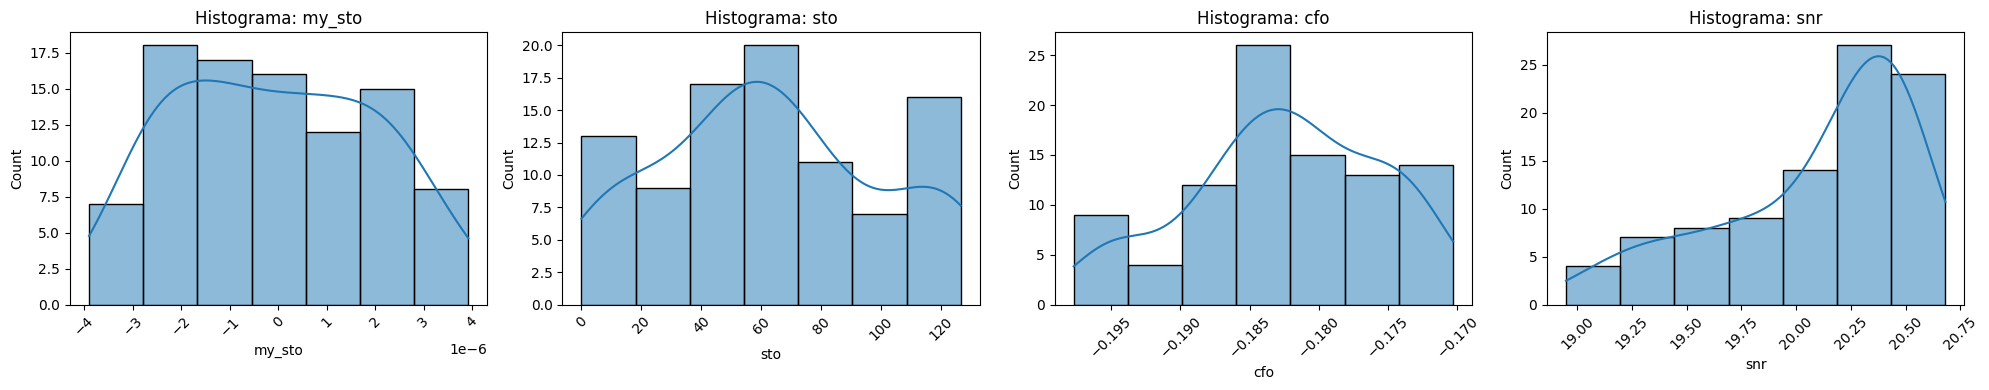

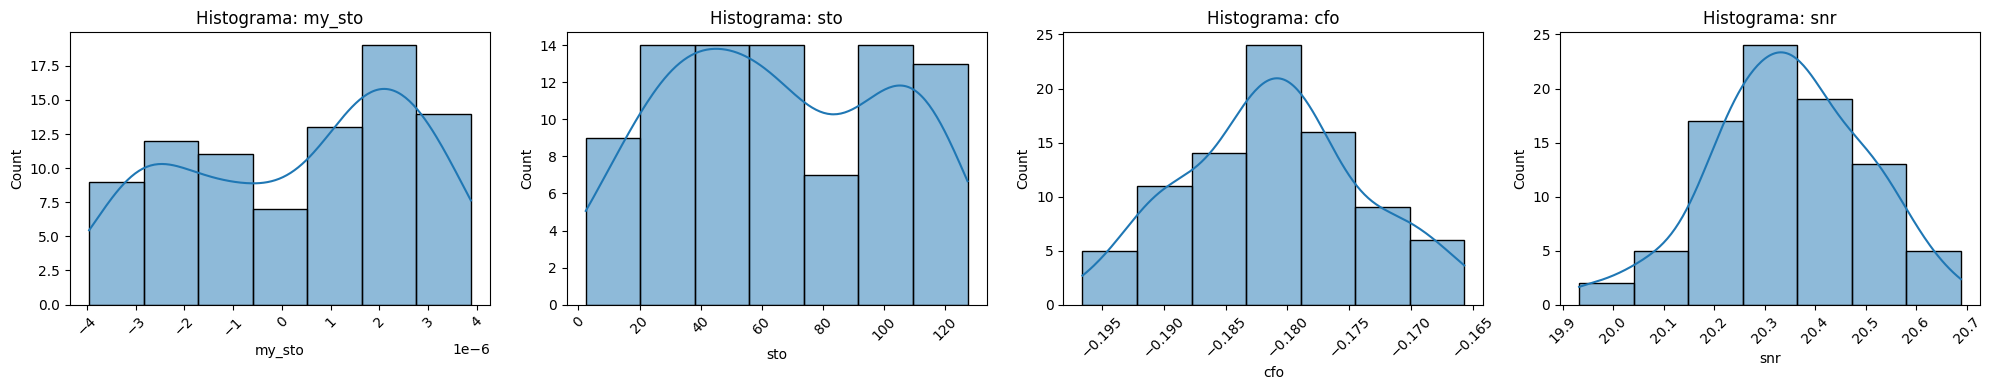

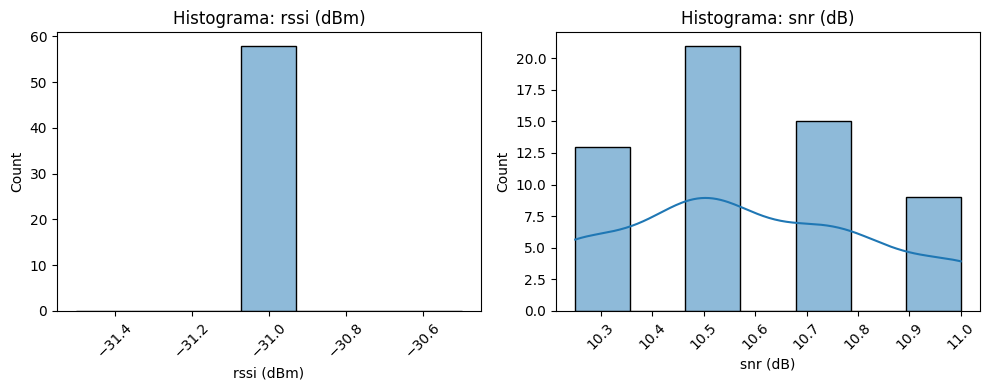

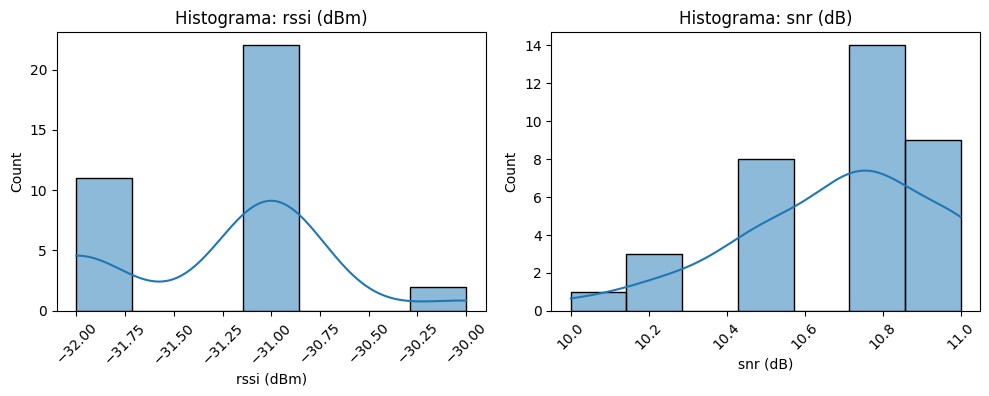

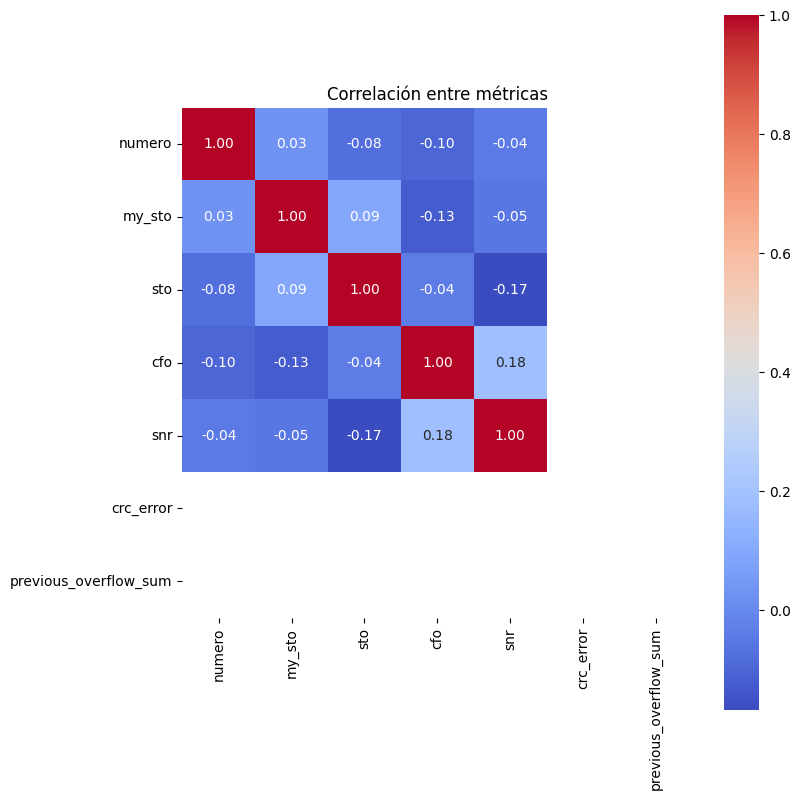

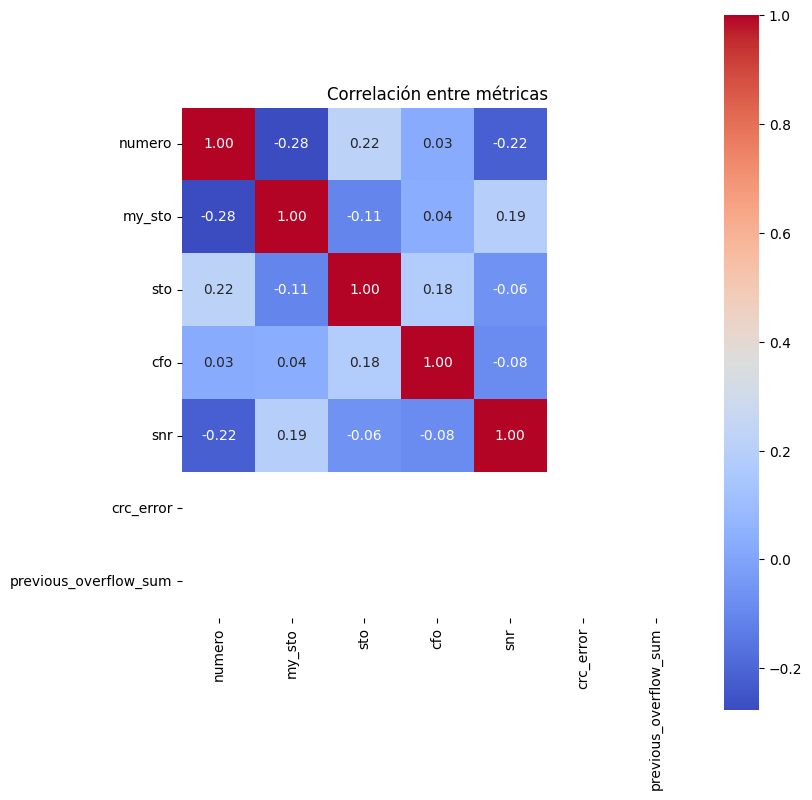

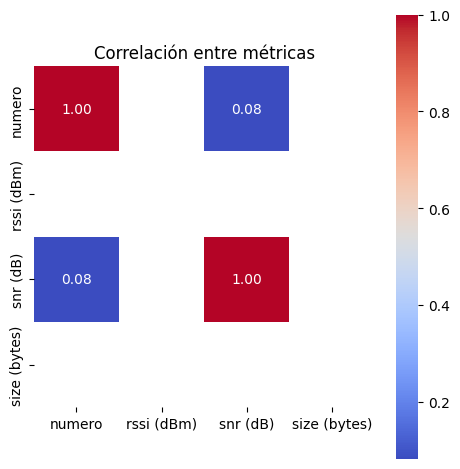

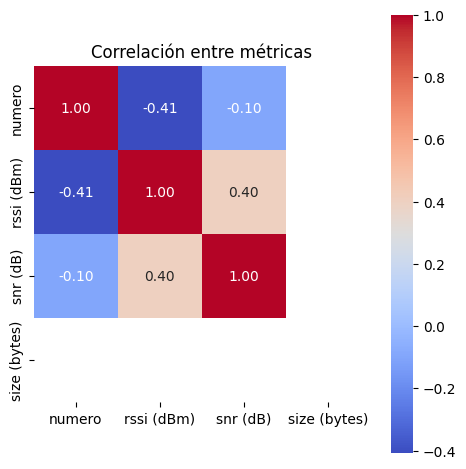

In [377]:
plot_histograma(df_4M1M)
plot_histograma(df_8M1M)
plot_histograma(df_N_4M1M)
plot_histograma(df_N_8M1M)

plot_correlacion(df_4M1M)
plot_correlacion(df_8M1M)
plot_correlacion(df_N_4M1M)
plot_correlacion(df_N_8M1M)

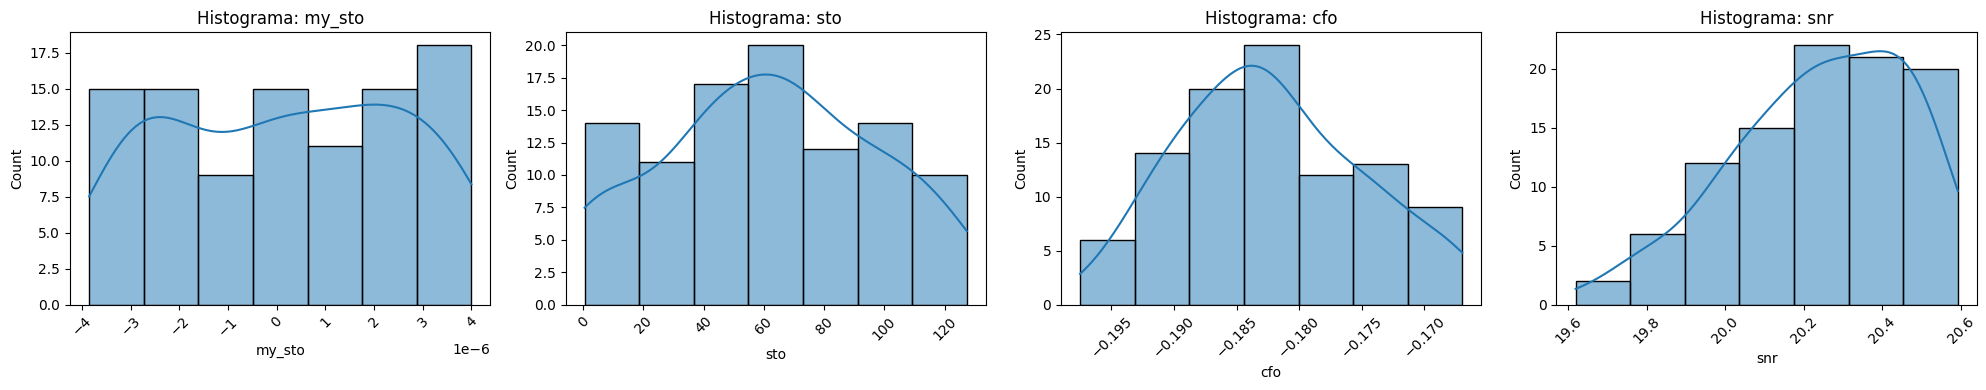

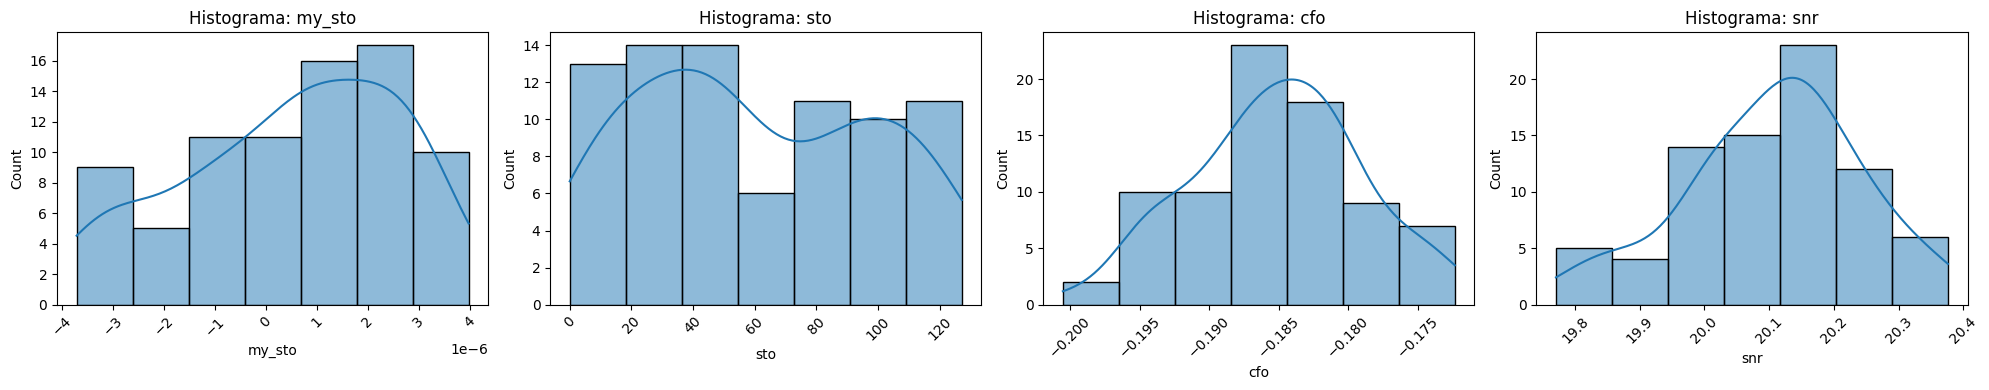

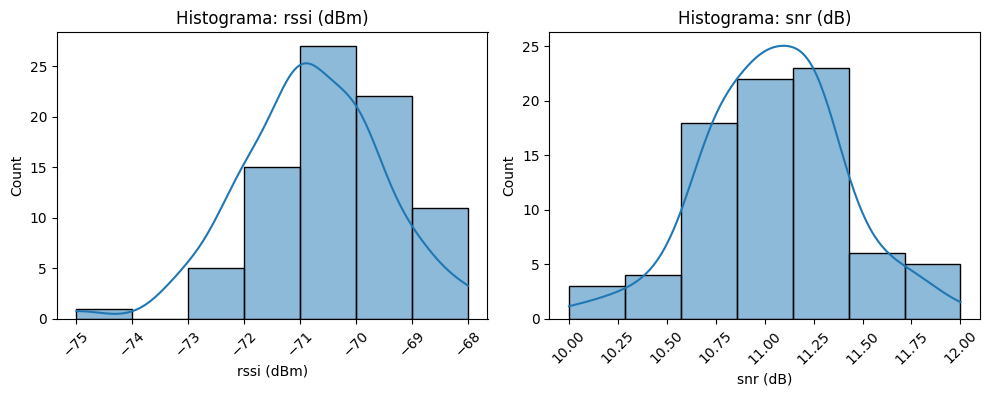

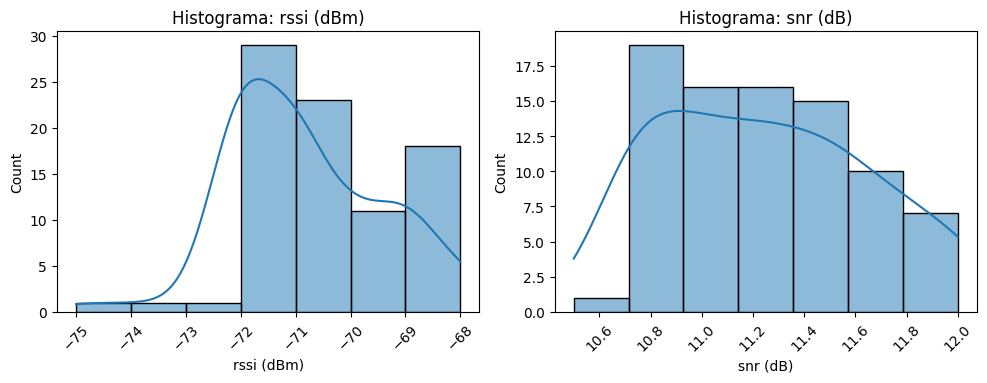

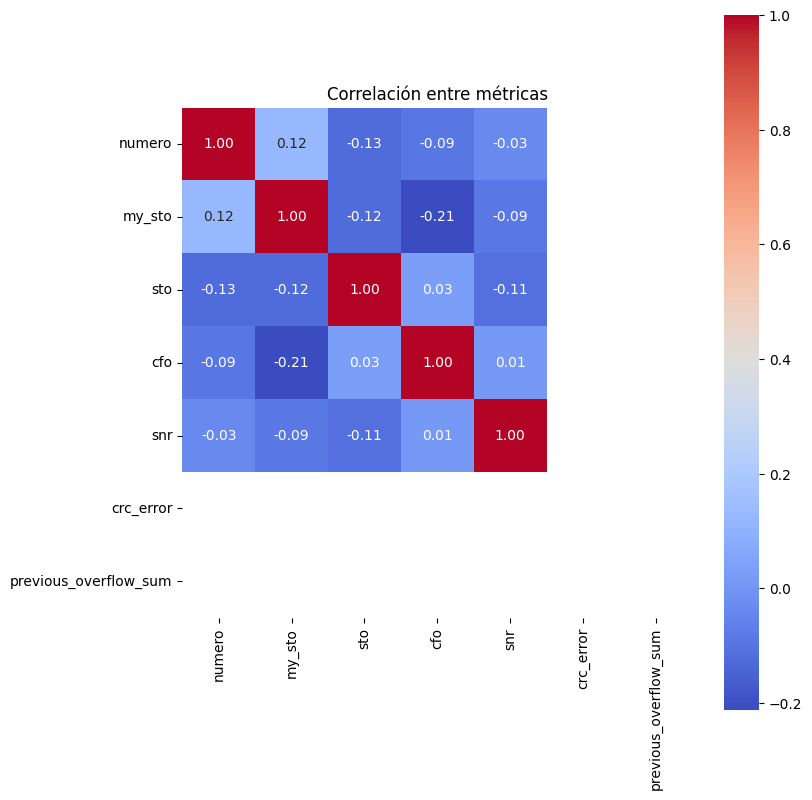

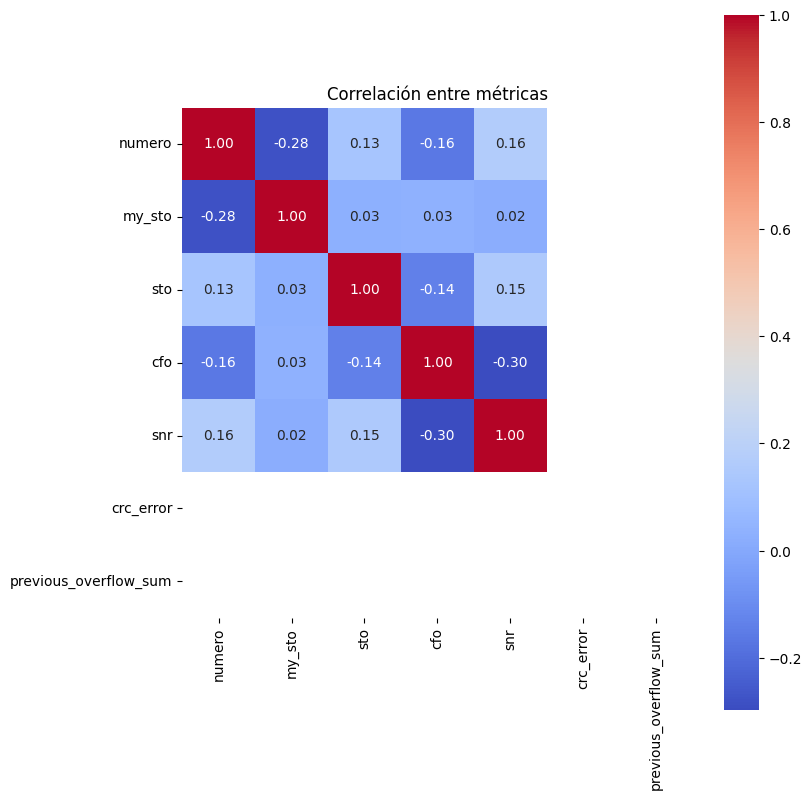

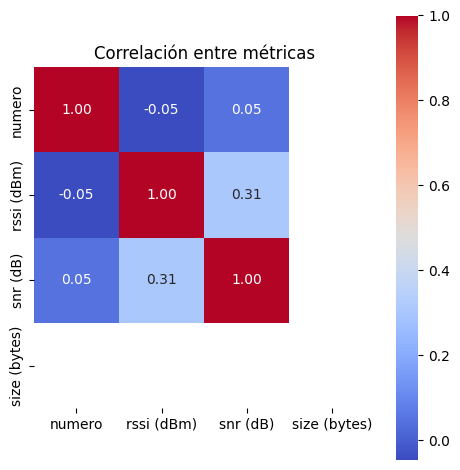

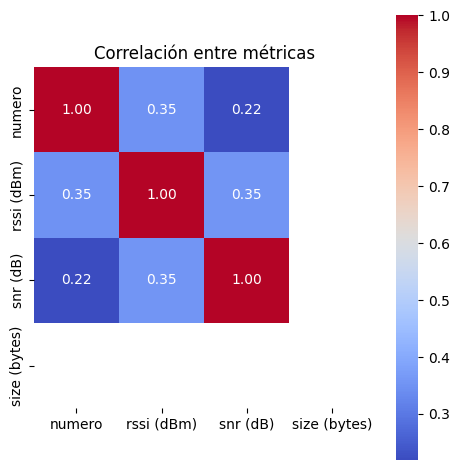

In [378]:
plot_histograma(df_4M40M)
plot_histograma(df_8M40M)
plot_histograma(df_N_4M40M)
plot_histograma(df_N_8M40M)

plot_correlacion(df_4M40M)
plot_correlacion(df_8M40M)
plot_correlacion(df_N_4M40M)
plot_correlacion(df_N_8M40M)

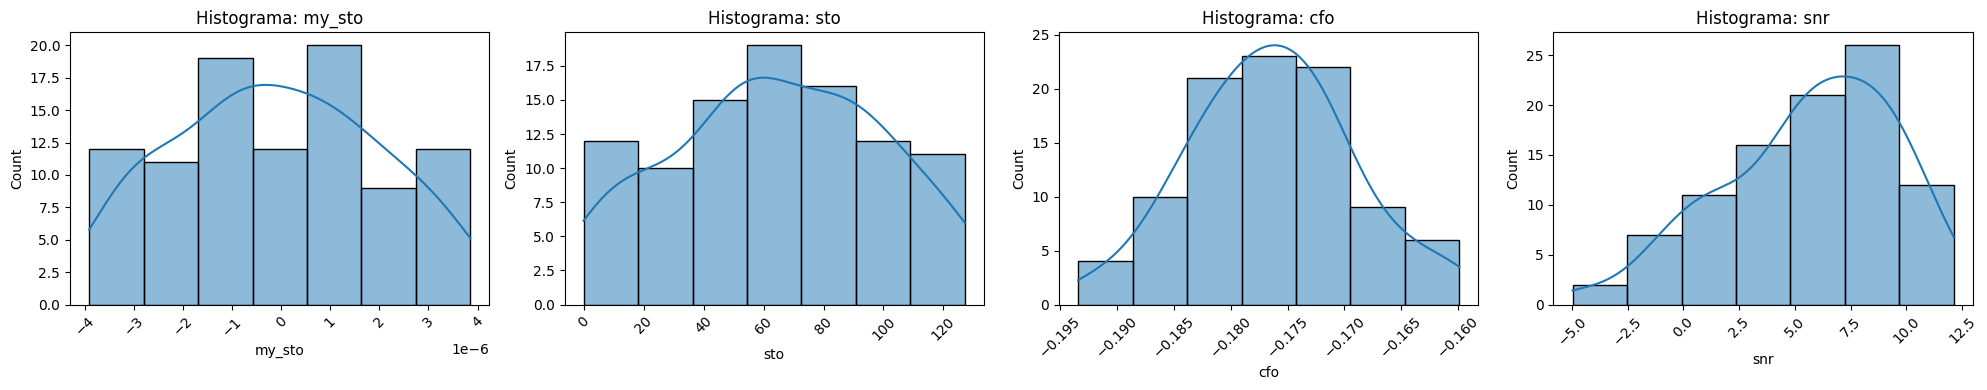

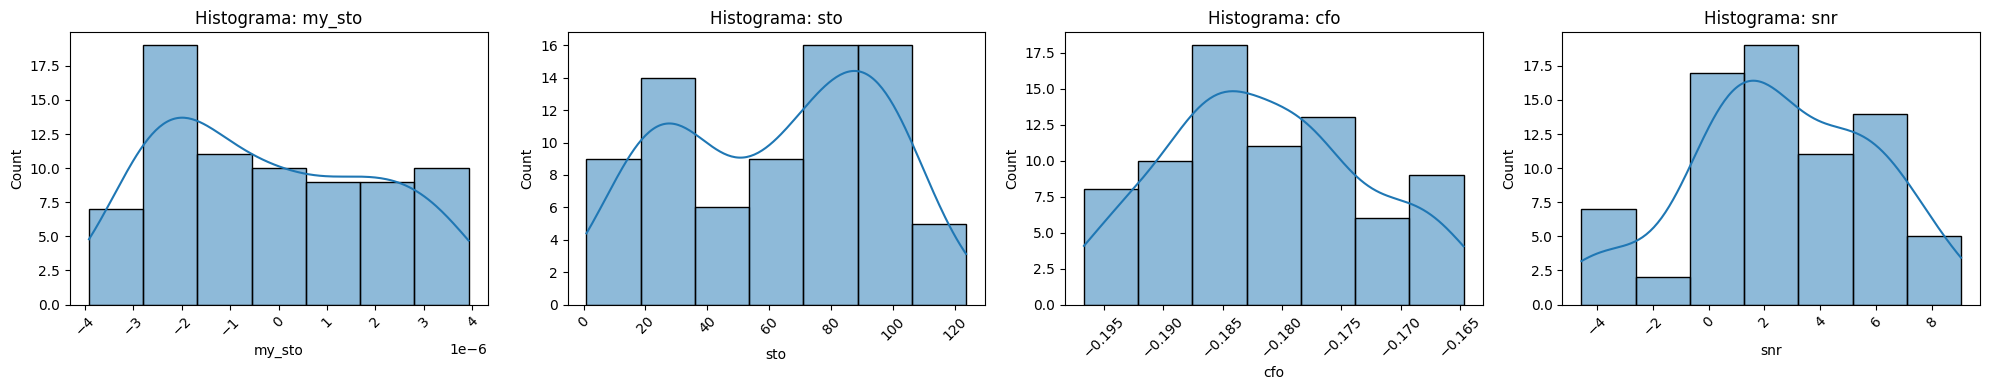

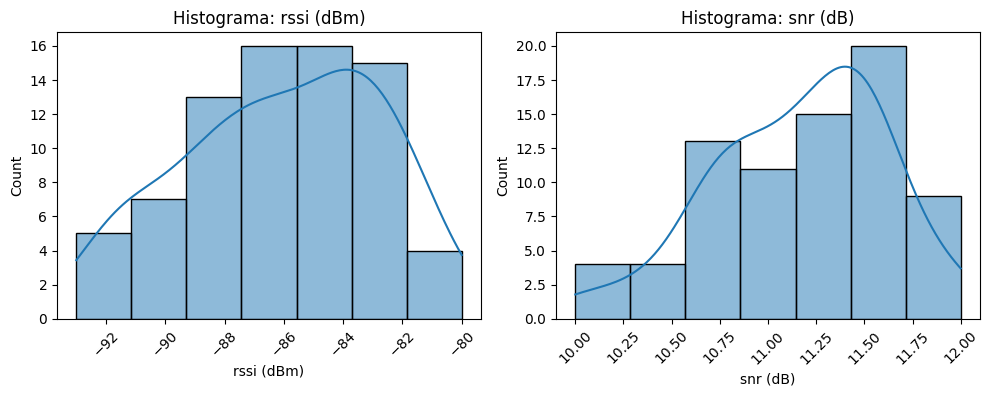

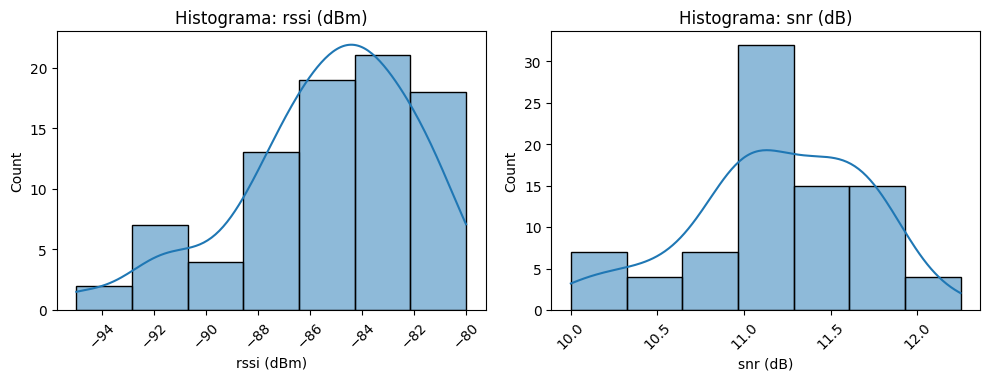

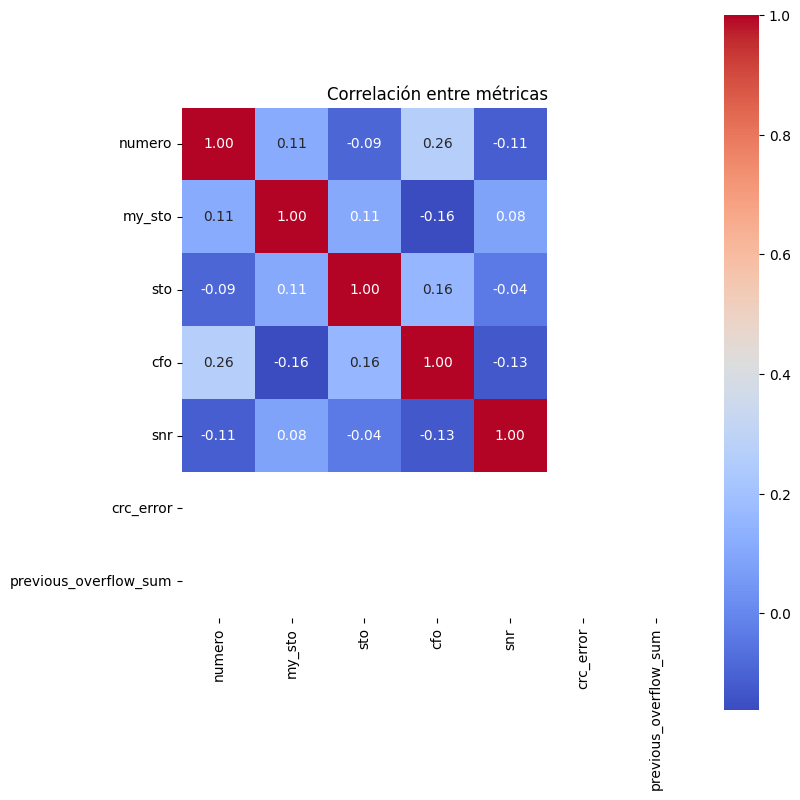

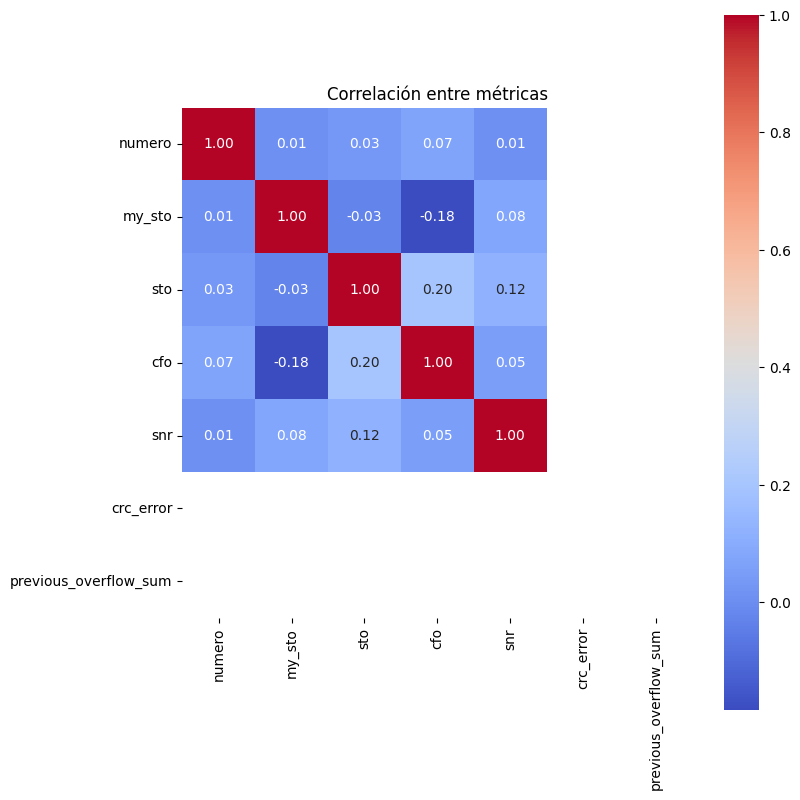

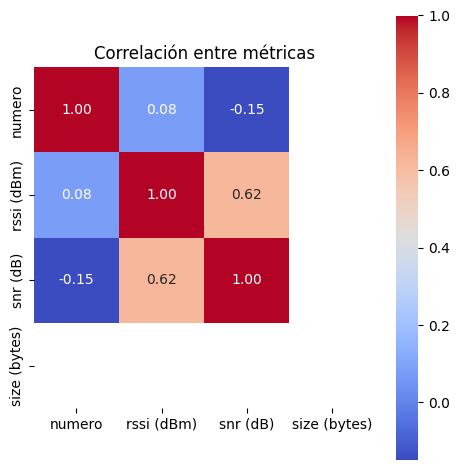

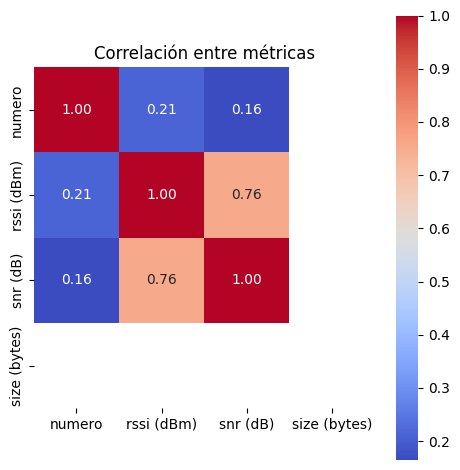

In [379]:
plot_histograma(df_4M80M)
plot_histograma(df_8M80M)
plot_histograma(df_N_4M80M)
plot_histograma(df_N_8M80M)


plot_correlacion(df_4M80M)
plot_correlacion(df_8M80M)
plot_correlacion(df_N_4M80M)
plot_correlacion(df_N_8M80M)

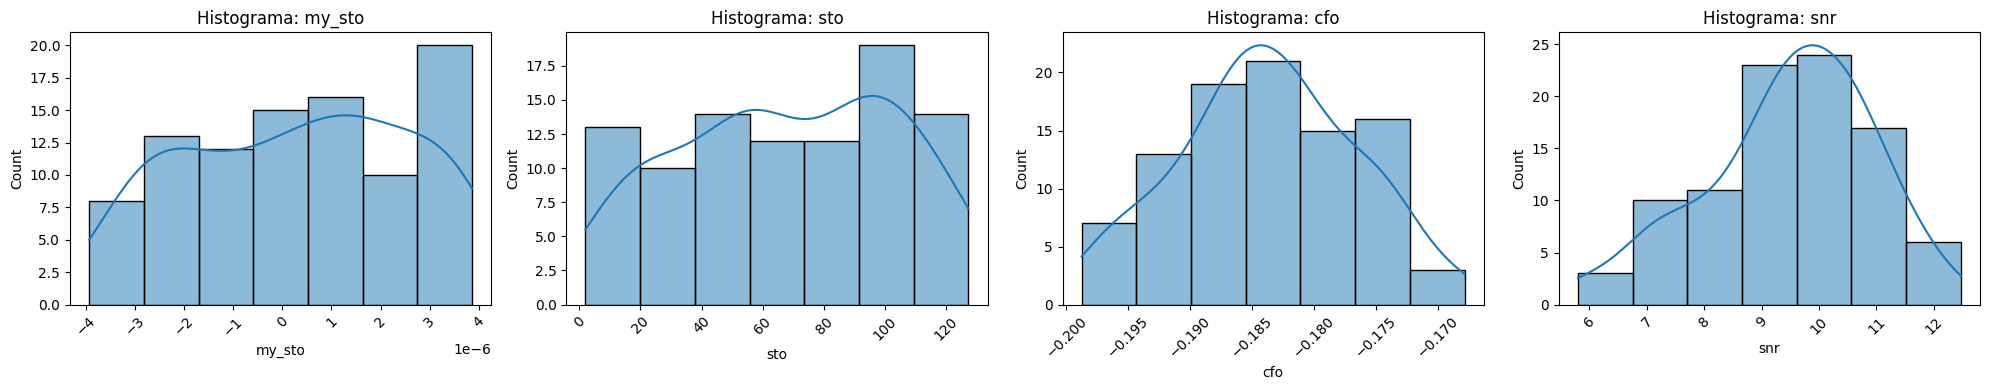

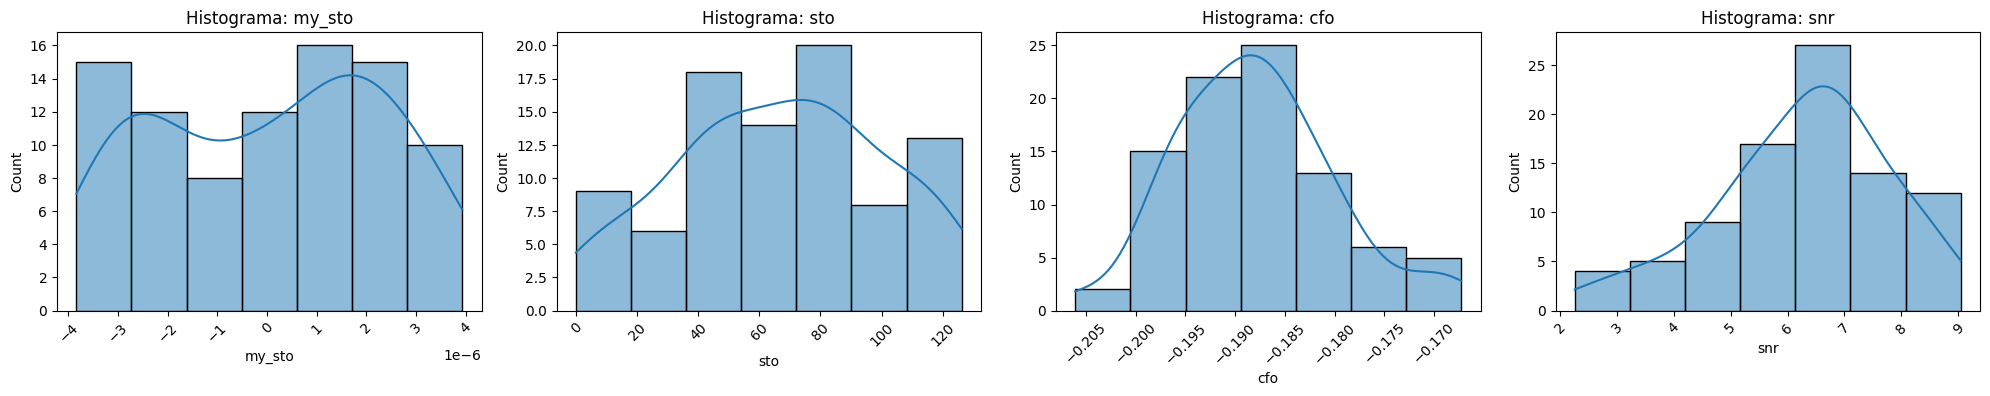

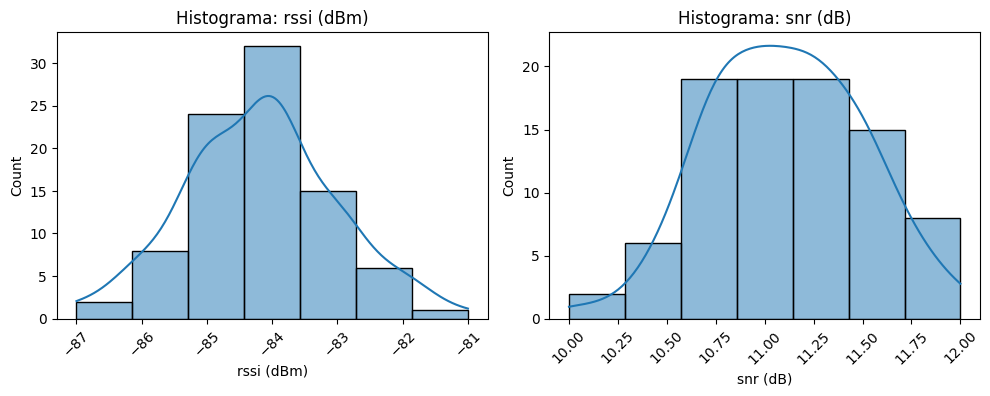

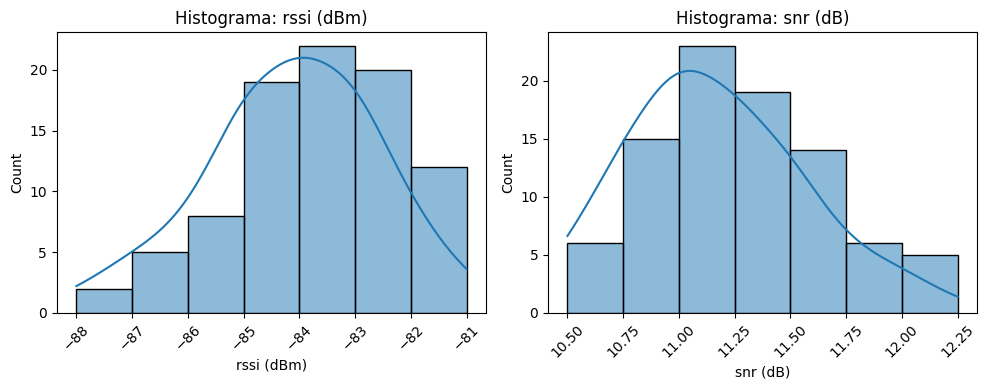

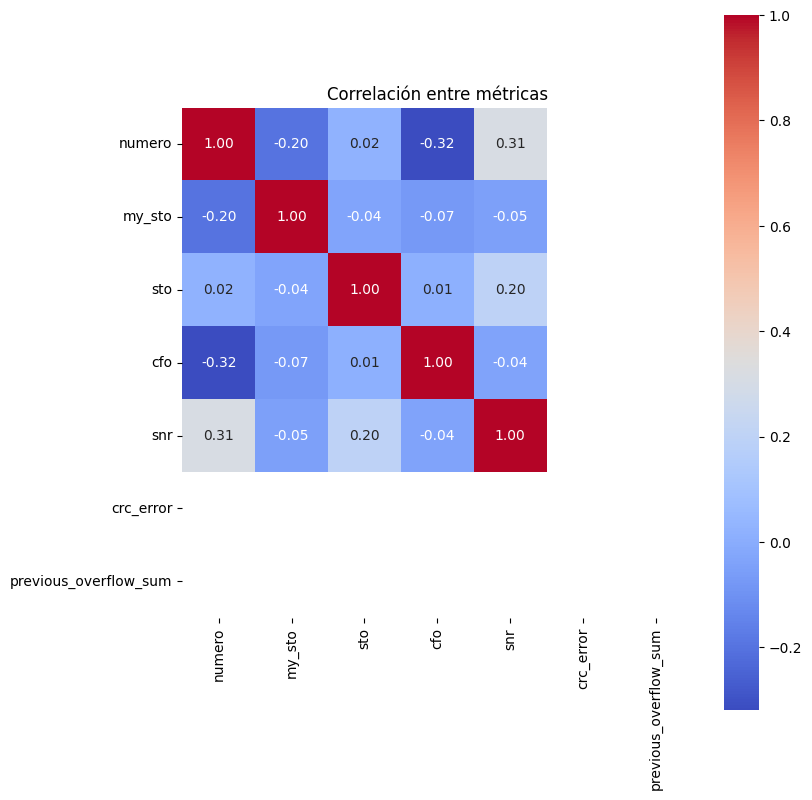

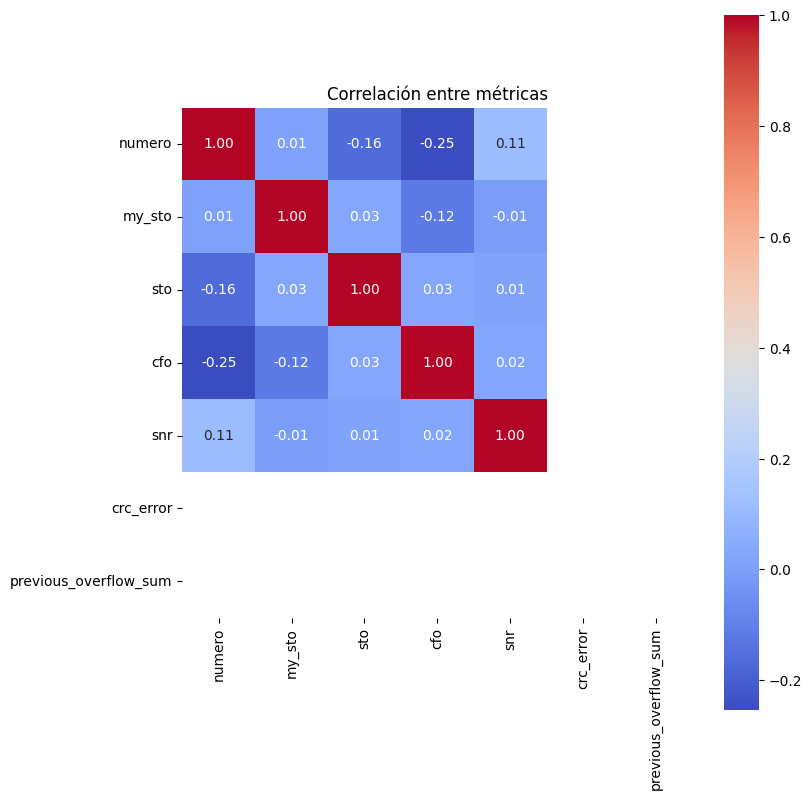

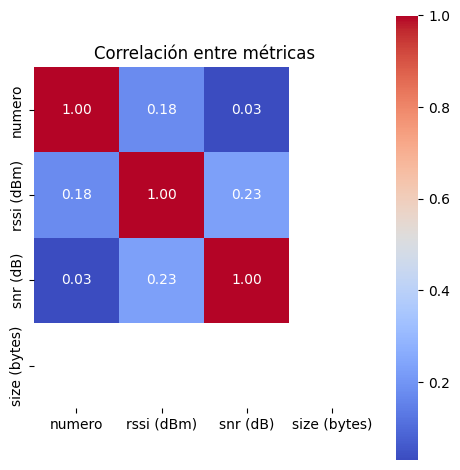

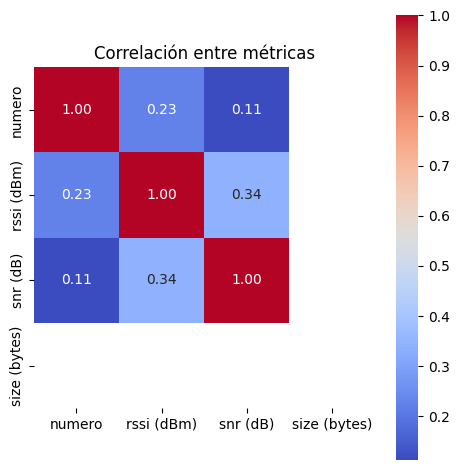

In [380]:
plot_histograma(df_4M120M)
plot_histograma(df_8M120M)
plot_histograma(df_N_4M120M)
plot_histograma(df_N_8M120M)

plot_correlacion(df_4M120M)
plot_correlacion(df_8M120M)
plot_correlacion(df_N_4M120M)
plot_correlacion(df_N_8M120M)

### Pruebas Estadísticas

El propósito de este análisis es demostrar si estas se encuentran afectadas significativamente por la distancia o no. Las variables relevantes en el dataset para determinar esta relación son `my_sto`, `sto`, `snr` y `cfo`. El entorno de pruebas fue dividido en dos datasets. Uno con los datos a 4Mbps y otro a 8Mbps, con la columna `distancia` como el valor sobre el que se hará la agrupación.

Se realizaron pruebas Shapiro-Wilk para comprobar normalidad junto con Levene para comprobar su homocedasticidad. Para el dataset de 8Mpbs, `snr` y `cfo` presentaron varianzas desiguales con normalidad, por lo que se aplicó Anova Welch [1]. El resto de datos no cumplieron ninguno de estos supuestos; Anova y Anova Welch fueron descartados para ellos. Por ende, se optó por utilizar Kruskal-Wallis, adecuada para datos desbalanceados y con distribución no normal [2].

[1] Laerd Statistics, One-way ANOVA using SPSS Statistics. [Online]. Available: https://statistics.laerd.com/spss-tutorials/one-way-anova-using-spss-statistics.php.

[2] J. H. McDonald, Handbook of Biological Statistics, 3rd ed. Baltimore, MD: Sparky House Publishing, 2014. [Online]. Available: http://www.biostathandbook.com/kruskalwallis.html


In [381]:
metricas = ['my_sto', 'sto', 'snr', 'cfo']
resultados_4M = []
resultados_8M = []

In [382]:
df_completo_4M = pd.concat([df_4M1M, df_4M40M, df_4M80M, df_4M120M], ignore_index=True)
df_completo_4M['distancia'] = df_completo_4M['prueba'].apply(extraer_distancia)
df_completo_4M['distancia'] = df_completo_4M['distancia'].astype(float)

df_completo_8M = pd.concat([df_8M1M, df_8M40M, df_8M80M, df_8M120M], ignore_index=True)
df_completo_8M['distancia'] = df_completo_8M['prueba'].apply(extraer_distancia)
df_completo_8M['distancia'] = df_completo_8M['distancia'].astype(float)

display(df_completo_4M)
display(df_completo_8M)

,mensaje,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum,prueba,distancia
0,1M 4MSPS:0,0,5.400320e-07,48.0674,-0.177525,20.63170,0,0,4M-1m-1,1.0
1,1M 4MSPS:01,1,1.019250e-06,59.1273,-0.180525,18.94880,0,0,4M-1m-1,1.0
2,1M 4MSPS:02,2,2.484900e-06,57.3105,-0.185939,20.39110,0,0,4M-1m-1,1.0
3,1M 4MSPS:03,3,1.044650e-06,19.1305,-0.179333,20.40810,0,0,4M-1m-1,1.0
4,1M 4MSPS:04,4,1.820470e-06,123.2270,-0.182460,20.01830,0,0,4M-1m-1,1.0
...,...,...,...,...,...,...,...,...,...,...
375,120M 4MSPS:098,98,-2.801710e-06,112.6500,-0.197242,11.66840,0,0,4M-120m-1,120.0
376,120M 4MSPS:099,99,-3.131090e-06,79.6085,-0.192853,10.56320,0,0,4M-120m-1,120.0
377,120M 4MSPS:0100,100,1.011010e-06,99.1263,-0.182075,9.38963,0,0,4M-120m-1,120.0
378,120M 4MSPS:0101,101,-1.523350e-06,68.8095,-0.176680,9.29473,0,0,4M-120m-1,120.0


,mensaje,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum,prueba,distancia
0,1M 8MSPS:0,0,2.799170e-07,58.0349,-0.182969,20.29080,0,0,8M-1m-1,1.0
1,1M 8MSPS:01,1,1.550390e-06,89.1937,-0.184022,20.30640,0,0,8M-1m-1,1.0
2,1M 8MSPS:02,2,4.983300e-07,46.0622,-0.179368,20.68830,0,0,8M-1m-1,1.0
3,1M 8MSPS:04,4,2.950420e-06,6.3687,-0.184068,20.24720,0,0,8M-1m-1,1.0
4,1M 8MSPS:05,5,2.558040e-06,67.3196,-0.187601,20.40840,0,0,8M-1m-1,1.0
...,...,...,...,...,...,...,...,...,...,...
322,120M 8MSPS:097,97,2.592890e-06,82.3240,-0.193023,9.04268,0,0,8M-120m-1,120.0
323,120M 8MSPS:099,99,1.702620e-06,75.2127,-0.193827,5.55124,0,0,8M-120m-1,120.0
324,120M 8MSPS:0100,100,-1.625570e-07,119.9800,-0.185851,6.38404,0,0,8M-120m-1,120.0
325,120M 8MSPS:0101,101,3.065710e-06,8.3831,-0.196819,5.52251,0,0,8M-120m-1,120.0


In [383]:
for metrica in metricas:
    if metrica in df_completo_4M.columns:
        resultado = comparar_metricas_por_distancia(df_completo_4M, metrica, columna_grupo='distancia')
        resultados_4M.append(resultado)

pd.DataFrame(resultados_4M)

,metrica,test,p-valor
0,my_sto,Kruskal-Wallis,4.777438e-01
1,sto,Kruskal-Wallis,5.747630e-01
2,snr,Kruskal-Wallis,1.481672e-64
3,cfo,Kruskal-Wallis,1.247487e-10


In [384]:
for metrica in metricas:
    if metrica in df_completo_8M.columns:
        resultado = comparar_metricas_por_distancia(df_completo_8M, metrica, columna_grupo='distancia')
        resultados_8M.append(resultado)

pd.DataFrame(resultados_8M)

,metrica,test,p-valor
0,my_sto,Kruskal-Wallis,2.424116e-01
1,sto,Kruskal-Wallis,6.037720e-01
2,snr,ANOVA de Welch,6.638518e-143
3,cfo,ANOVA de Welch,6.612158e-09


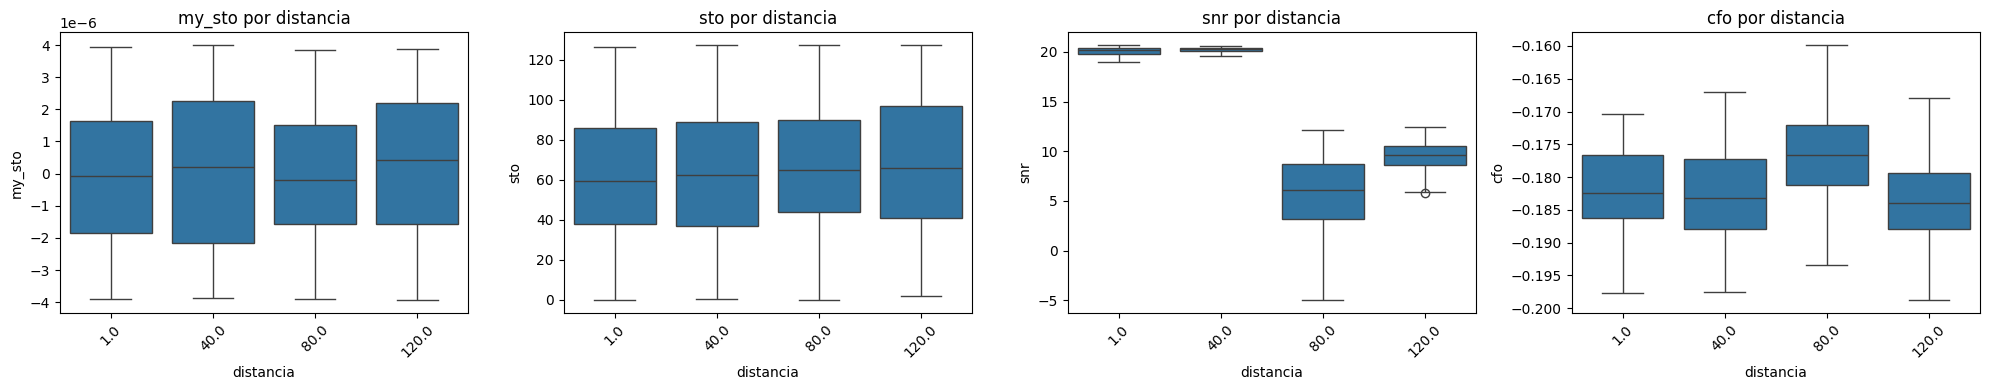

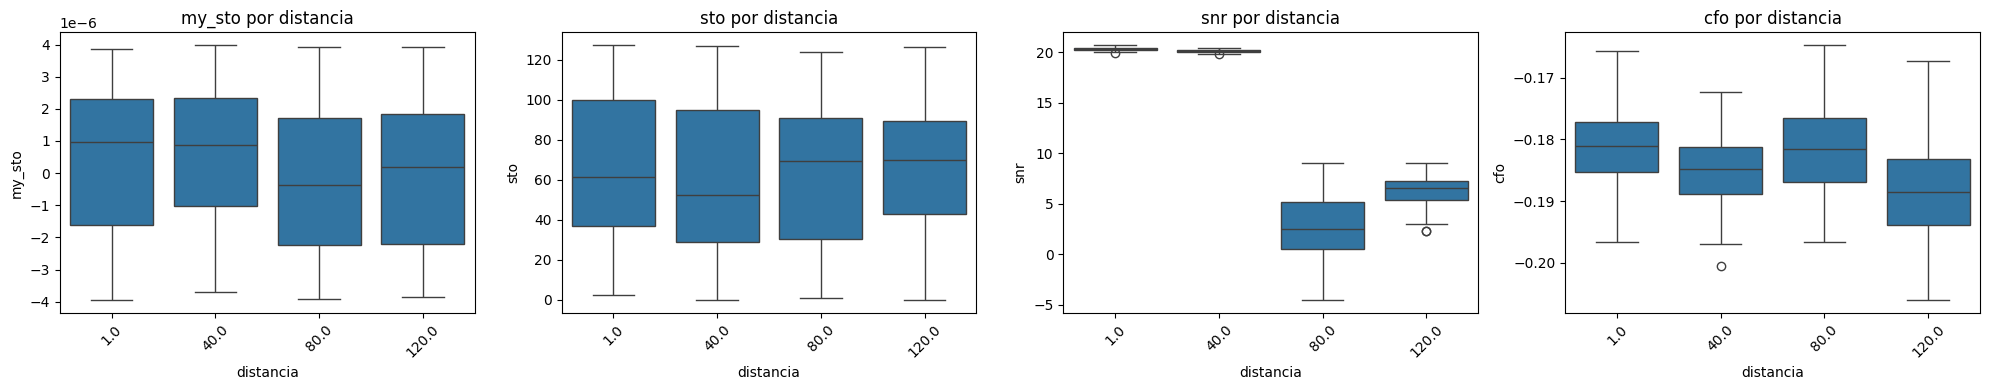

In [385]:
plot_metricas_por_distancia(df_completo_4M, metricas, tipo='box', columna_grupo='distancia')
plot_metricas_por_distancia(df_completo_8M, metricas, tipo='box', columna_grupo='distancia')

## Modelo de Propagación

In [386]:
df_completo_N_4M = pd.concat([df_N_4M1M, df_N_4M40M, df_N_4M80M, df_N_4M120M,], ignore_index=True)
df_completo_N_4M['distancia'] = df_completo_N_4M['prueba'].apply(extraer_distancia)
df_completo_N_4M['distancia'] = df_completo_N_4M['distancia'].astype(float)

df_completo_N_8M = pd.concat([df_N_8M1M, df_N_8M40M, df_N_8M80M, df_N_8M120M,], ignore_index=True)
df_completo_N_8M['distancia'] = df_completo_N_8M['prueba'].apply(extraer_distancia)
df_completo_N_8M['distancia'] = df_completo_N_8M['distancia'].astype(float)

display(df_completo_N_4M)
display(df_completo_N_8M)

,mensaje,numero,rssi (dBm),snr (dB),size (bytes),prueba,distancia
0,1M 4MSPS:010,10,-31,10.50,12,1m4msps,1.0
1,1M 4MSPS:011,11,-31,10.75,12,1m4msps,1.0
2,1M 4MSPS:012,12,-31,10.25,12,1m4msps,1.0
3,1M 4MSPS:014,14,-31,11.00,12,1m4msps,1.0
4,1M 4MSPS:016,16,-31,10.25,12,1m4msps,1.0
...,...,...,...,...,...,...,...
298,120M 4MSPS:095,95,-84,11.00,14,120m4msps,120.0
299,120M 4MSPS:096,96,-84,11.00,14,120m4msps,120.0
300,120M 4MSPS:097,97,-86,10.50,14,120m4msps,120.0
301,120M 4MSPS:098,98,-84,11.25,14,120m4msps,120.0


,mensaje,numero,rssi (dBm),snr (dB),size (bytes),prueba,distancia
0,1M 8MSPS:010,10,-30,10.75,12,1m8msps,1.0
1,1M 8MSPS:011,11,-30,11.00,12,1m8msps,1.0
2,1M 8MSPS:012,12,-31,11.00,12,1m8msps,1.0
3,1M 8MSPS:013,13,-31,10.50,12,1m8msps,1.0
4,1M 8MSPS:014,14,-31,10.75,12,1m8msps,1.0
...,...,...,...,...,...,...,...
286,120M 8MSPS:094,94,-83,11.25,14,120m8msps,120.0
287,120M 8MSPS:095,95,-83,11.25,14,120m8msps,120.0
288,120M 8MSPS:097,97,-84,10.75,14,120m8msps,120.0
289,120M 8MSPS:098,98,-82,11.50,14,120m8msps,120.0


Modelo ajustado:
   rssi (dBm) ≈ -30.69 + (-26.63) * log10(distancia)
   Pérdida (n) ≈ 2.66


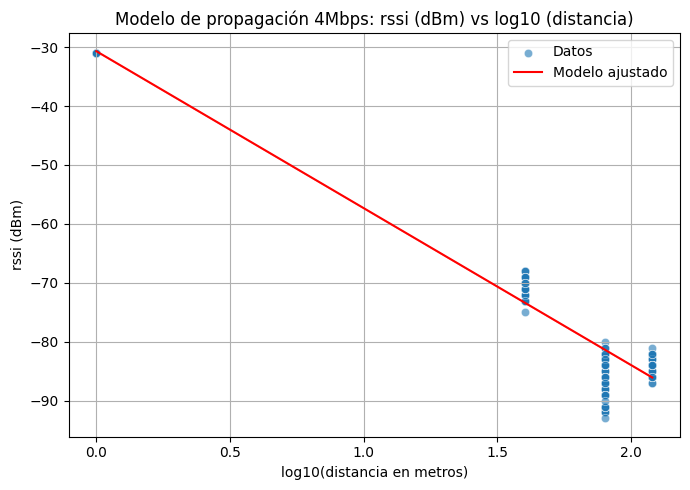

In [387]:
df_modelo = df_completo_N_4M[df_completo_N_4M['rssi (dBm)'].notna() & df_completo_N_4M['distancia'].notna() & (df_completo_N_4M['distancia'] > 0)].copy()

df_modelo['log_distancia'] = np.log10(df_modelo['distancia'])

X = df_modelo[['log_distancia']]
y = df_modelo['rssi (dBm)']

modelo = LinearRegression()
modelo.fit(X, y)

intercepto = modelo.intercept_
pendiente = modelo.coef_[0]
n = -pendiente / 10  # Interpretación: -10n * log10(d)

print(f"Modelo ajustado:")
print(f"   rssi (dBm) ≈ {intercepto:.2f} + ({pendiente:.2f}) * log10(distancia)")
print(f"   Pérdida (n) ≈ {n:.2f}")

plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_modelo, x='log_distancia', y='rssi (dBm)', alpha=0.6, label='Datos')
sns.lineplot(x=df_modelo['log_distancia'], y=modelo.predict(X), color='red', label='Modelo ajustado')
plt.title("Modelo de propagación 4Mbps: rssi (dBm) vs log10 (distancia)")
plt.xlabel("log10(distancia en metros)")
plt.ylabel("rssi (dBm)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Modelo ajustado:
   rssi (dBm) ≈ -30.75 + (-26.53) * log10(distancia)
   Pérdida (n) ≈ 2.65


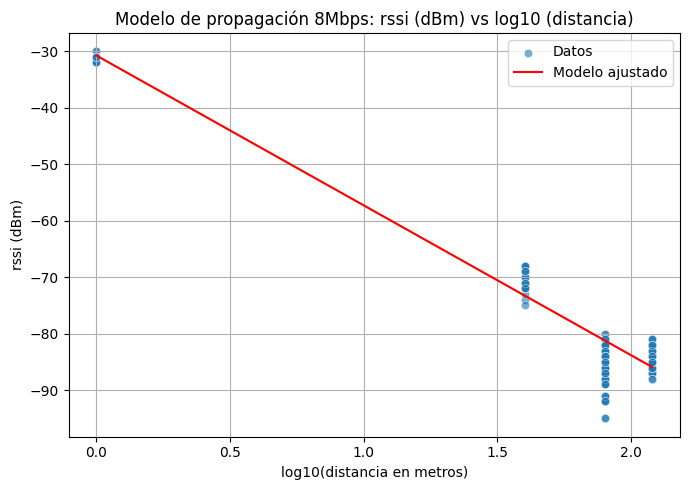

In [388]:
df_modelo = df_completo_N_8M[df_completo_N_8M['rssi (dBm)'].notna() & df_completo_N_8M['distancia'].notna() & (df_completo_N_8M['distancia'] > 0)].copy()

df_modelo['log_distancia'] = np.log10(df_modelo['distancia'])

X = df_modelo[['log_distancia']]
y = df_modelo['rssi (dBm)']

modelo = LinearRegression()
modelo.fit(X, y)

intercepto = modelo.intercept_
pendiente = modelo.coef_[0]
n = -pendiente / 10  # Interpretación: -10n * log10(d)

print(f"Modelo ajustado:")
print(f"   rssi (dBm) ≈ {intercepto:.2f} + ({pendiente:.2f}) * log10(distancia)")
print(f"   Pérdida (n) ≈ {n:.2f}")

plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_modelo, x='log_distancia', y='rssi (dBm)', alpha=0.6, label='Datos')
sns.lineplot(x=df_modelo['log_distancia'], y=modelo.predict(X), color='red', label='Modelo ajustado')
plt.title("Modelo de propagación 8Mbps: rssi (dBm) vs log10 (distancia)")
plt.xlabel("log10(distancia en metros)")
plt.ylabel("rssi (dBm)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()